In [2]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [3]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [4]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [5]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [6]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

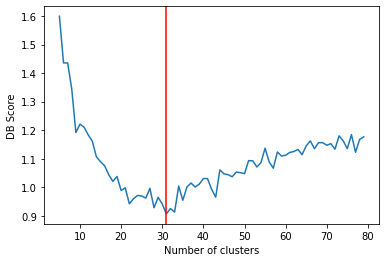

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}


In [7]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

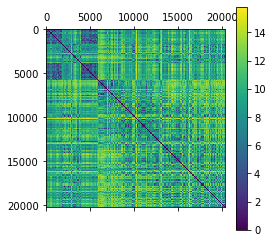

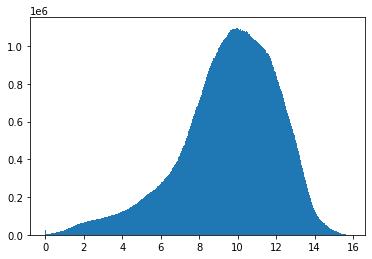

In [8]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

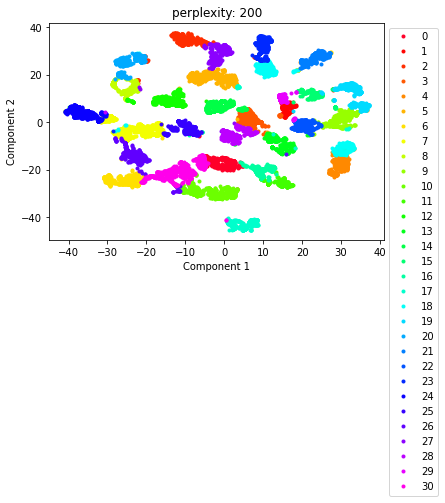

In [9]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [10]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [11]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [12]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [13]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [14]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9787611491647366


In [15]:
losses = []
accs = []
sparsity = []

In [16]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.2774474382030967
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.8344267955801106
layer 6: 0.587189226519337
layer 7: 0.43266574585635365
layer 8: 0.25496374309392267
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.433 | Reg loss: 0.019 | Tree loss: 3.433 | Accuracy: 0.047000 | 3.93 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.426 | Reg loss: 0.018 | Tree loss: 3.426 | Accuracy: 0.071000 | 4.06 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.421 | Reg loss: 0.018 | Tree loss: 3.421 | Accuracy: 0.094000 | 4.134 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.412 | Reg loss: 0.018 | Tree loss: 3.412 | Accuracy: 0.109000 | 4.185 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.404 | Reg loss: 0.018 | Tree loss: 3.404 | Accuracy: 0.145000 | 4.18 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 3.402 | Reg loss: 0.018 | Tree loss: 3.402 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 3.400 | Reg loss: 0.016 | Tree loss: 3.400 | Accuracy: 0.131000 | 4.118 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.390 | Reg loss: 0.016 | Tree loss: 3.390 | Accuracy: 0.135000 | 4.111 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 3.373 | Reg loss: 0.016 | Tree loss: 3.373 | Accuracy: 0.190500 | 4.091 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 3.355 | Reg loss: 0.016 | Tree loss: 3.355 | Accuracy: 0.189500 | 4.078 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 3.340 | Reg loss: 0.016 | Tree loss: 3.340 | Accuracy: 0.171000 | 4.062 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 3.323 | Reg loss: 0.016 | Tree loss: 3.323 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 3.336 | Reg loss: 0.018 | Tree loss: 3.336 | Accuracy: 0.188000 | 4.151 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 3.293 | Reg loss: 0.018 | Tree loss: 3.293 | Accuracy: 0.225500 | 4.153 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 3.254 | Reg loss: 0.018 | Tree loss: 3.254 | Accuracy: 0.215000 | 4.152 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 3.215 | Reg loss: 0.019 | Tree loss: 3.215 | Accuracy: 0.202000 | 4.148 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 3.179 | Reg loss: 0.019 | Tree loss: 3.179 | Accuracy: 0.175500 | 4.146 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 3.154 | Reg loss: 0.019 | Tree loss: 3.154 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 3.191 | Reg loss: 0.021 | Tree loss: 3.191 | Accuracy: 0.222000 | 4.162 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 3.140 | Reg loss: 0.021 | Tree loss: 3.140 | Accuracy: 0.235500 | 4.161 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 3.086 | Reg loss: 0.021 | Tree loss: 3.086 | Accuracy: 0.231000 | 4.161 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 3.010 | Reg loss: 0.021 | Tree loss: 3.010 | Accuracy: 0.238500 | 4.161 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 2.988 | Reg loss: 0.022 | Tree loss: 2.988 | Accuracy: 0.223000 | 4.162 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 2.928 | Reg loss: 0.022 | Tree loss: 2.928 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 3.011 | Reg loss: 0.023 | Tree loss: 3.011 | Accuracy: 0.231500 | 4.141 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 2.967 | Reg loss: 0.024 | Tree loss: 2.967 | Accuracy: 0.210000 | 4.139 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 2.891 | Reg loss: 0.024 | Tree loss: 2.891 | Accuracy: 0.238000 | 4.136 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 2.836 | Reg loss: 0.024 | Tree loss: 2.836 | Accuracy: 0.239000 | 4.126 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 2.794 | Reg loss: 0.024 | Tree loss: 2.794 | Accuracy: 0.250000 | 4.118 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 2.757 | Reg loss: 0.024 | Tree loss: 2.757 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 2.839 | Reg loss: 0.025 | Tree loss: 2.839 | Accuracy: 0.232000 | 4.083 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 2.792 | Reg loss: 0.025 | Tree loss: 2.792 | Accuracy: 0.235500 | 4.081 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 2.714 | Reg loss: 0.025 | Tree loss: 2.714 | Accuracy: 0.237000 | 4.078 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 2.655 | Reg loss: 0.025 | Tree loss: 2.655 | Accuracy: 0.258500 | 4.078 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 2.618 | Reg loss: 0.025 | Tree loss: 2.618 | Accuracy: 0.269500 | 4.076 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 2.589 | Reg loss: 0.026 | Tree loss: 2.589 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 2.666 | Reg loss: 0.026 | Tree loss: 2.666 | Accuracy: 0.242500 | 4.028 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 2.611 | Reg loss: 0.026 | Tree loss: 2.611 | Accuracy: 0.241000 | 4.027 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 2.557 | Reg loss: 0.027 | Tree loss: 2.557 | Accuracy: 0.269500 | 4.027 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 2.499 | Reg loss: 0.027 | Tree loss: 2.499 | Accuracy: 0.294000 | 4.026 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 2.452 | Reg loss: 0.027 | Tree loss: 2.452 | Accuracy: 0.287500 | 4.025 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 2.424 | Reg loss: 0.027 | Tree loss: 2.424 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 2.511 | Reg loss: 0.027 | Tree loss: 2.511 | Accuracy: 0.260000 | 3.997 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 2.472 | Reg loss: 0.028 | Tree loss: 2.472 | Accuracy: 0.276500 | 3.997 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 2.471 | Reg loss: 0.028 | Tree loss: 2.471 | Accuracy: 0.268000 | 3.997 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 2.384 | Reg loss: 0.028 | Tree loss: 2.384 | Accuracy: 0.290000 | 3.997 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 2.360 | Reg loss: 0.028 | Tree loss: 2.360 | Accuracy: 0.303500 | 3.998 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 2.318 | Reg loss: 0.028 | Tree loss: 2.318 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 2.428 | Reg loss: 0.028 | Tree loss: 2.428 | Accuracy: 0.258000 | 3.985 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 2.389 | Reg loss: 0.028 | Tree loss: 2.389 | Accuracy: 0.278500 | 3.984 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 2.347 | Reg loss: 0.029 | Tree loss: 2.347 | Accuracy: 0.285000 | 3.983 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 2.281 | Reg loss: 0.029 | Tree loss: 2.281 | Accuracy: 0.294000 | 3.984 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 2.263 | Reg loss: 0.029 | Tree loss: 2.263 | Accuracy: 0.300500 | 3.984 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 2.240 | Reg loss: 0.029 | Tree loss: 2.240 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 2.307 | Reg loss: 0.029 | Tree loss: 2.307 | Accuracy: 0.299500 | 3.955 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 2.310 | Reg loss: 0.029 | Tree loss: 2.310 | Accuracy: 0.281500 | 3.954 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 2.278 | Reg loss: 0.029 | Tree loss: 2.278 | Accuracy: 0.284000 | 3.954 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 2.227 | Reg loss: 0.030 | Tree loss: 2.227 | Accuracy: 0.297000 | 3.953 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 2.203 | Reg loss: 0.030 | Tree loss: 2.203 | Accuracy: 0.289500 | 3.953 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 2.192 | Reg loss: 0.030 | Tree loss: 2.192 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 2.282 | Reg loss: 0.030 | Tree loss: 2.282 | Accuracy: 0.274500 | 3.943 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 2.262 | Reg loss: 0.030 | Tree loss: 2.262 | Accuracy: 0.273500 | 3.942 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 2.195 | Reg loss: 0.030 | Tree loss: 2.195 | Accuracy: 0.314500 | 3.942 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 2.188 | Reg loss: 0.030 | Tree loss: 2.188 | Accuracy: 0.300500 | 3.942 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 2.163 | Reg loss: 0.031 | Tree loss: 2.163 | Accuracy: 0.287500 | 3.943 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 2.132 | Reg loss: 0.031 | Tree loss: 2.132 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 2.231 | Reg loss: 0.031 | Tree loss: 2.231 | Accuracy: 0.280000 | 3.935 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 2.187 | Reg loss: 0.031 | Tree loss: 2.187 | Accuracy: 0.288000 | 3.935 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 2.166 | Reg loss: 0.031 | Tree loss: 2.166 | Accuracy: 0.313500 | 3.935 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 2.142 | Reg loss: 0.031 | Tree loss: 2.142 | Accuracy: 0.298500 | 3.935 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 2.148 | Reg loss: 0.032 | Tree loss: 2.148 | Accuracy: 0.301000 | 3.936 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 2.115 | Reg loss: 0.032 | Tree loss: 2.115 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 2.205 | Reg loss: 0.032 | Tree loss: 2.205 | Accuracy: 0.281000 | 3.938 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 2.156 | Reg loss: 0.032 | Tree loss: 2.156 | Accuracy: 0.305500 | 3.938 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 2.158 | Reg loss: 0.032 | Tree loss: 2.158 | Accuracy: 0.284000 | 3.938 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 2.118 | Reg loss: 0.032 | Tree loss: 2.118 | Accuracy: 0.288000 | 3.938 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 2.114 | Reg loss: 0.032 | Tree loss: 2.114 | Accuracy: 0.288000 | 3.938 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 2.055 | Reg loss: 0.032 | Tree loss: 2.055 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 2.162 | Reg loss: 0.033 | Tree loss: 2.162 | Accuracy: 0.278000 | 3.923 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 2.150 | Reg loss: 0.033 | Tree loss: 2.150 | Accuracy: 0.286500 | 3.922 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 2.109 | Reg loss: 0.033 | Tree loss: 2.109 | Accuracy: 0.299500 | 3.923 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 2.090 | Reg loss: 0.033 | Tree loss: 2.090 | Accuracy: 0.287000 | 3.923 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 2.064 | Reg loss: 0.033 | Tree loss: 2.064 | Accuracy: 0.307000 | 3.923 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 2.048 | Reg loss: 0.033 | Tree loss: 2.048 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 2.152 | Reg loss: 0.034 | Tree loss: 2.152 | Accuracy: 0.290000 | 3.921 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 2.109 | Reg loss: 0.034 | Tree loss: 2.109 | Accuracy: 0.283500 | 3.921 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 2.087 | Reg loss: 0.034 | Tree loss: 2.087 | Accuracy: 0.299000 | 3.921 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 2.076 | Reg loss: 0.034 | Tree loss: 2.076 | Accuracy: 0.299500 | 3.921 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 2.051 | Reg loss: 0.034 | Tree loss: 2.051 | Accuracy: 0.307500 | 3.921 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 2.012 | Reg loss: 0.034 | Tree loss: 2.012 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 2.099 | Reg loss: 0.035 | Tree loss: 2.099 | Accuracy: 0.289000 | 3.856 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 2.101 | Reg loss: 0.035 | Tree loss: 2.101 | Accuracy: 0.303000 | 3.855 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 2.034 | Reg loss: 0.035 | Tree loss: 2.034 | Accuracy: 0.310500 | 3.854 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 2.048 | Reg loss: 0.035 | Tree loss: 2.048 | Accuracy: 0.311500 | 3.852 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 2.012 | Reg loss: 0.035 | Tree loss: 2.012 | Accuracy: 0.326500 | 3.851 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 2.018 | Reg loss: 0.035 | Tree loss: 2.018 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 2.088 | Reg loss: 0.036 | Tree loss: 2.088 | Accuracy: 0.290000 | 3.77 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 2.058 | Reg loss: 0.036 | Tree loss: 2.058 | Accuracy: 0.308000 | 3.768 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 2.040 | Reg loss: 0.036 | Tree loss: 2.040 | Accuracy: 0.303500 | 3.766 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 2.012 | Reg loss: 0.036 | Tree loss: 2.012 | Accuracy: 0.326000 | 3.764 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 2.011 | Reg loss: 0.036 | Tree loss: 2.011 | Accuracy: 0.330000 | 3.762 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 1.988 | Reg loss: 0.036 | Tree loss: 1.988 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 2.067 | Reg loss: 0.036 | Tree loss: 2.067 | Accuracy: 0.292500 | 3.656 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 2.060 | Reg loss: 0.036 | Tree loss: 2.060 | Accuracy: 0.301000 | 3.654 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 2.054 | Reg loss: 0.036 | Tree loss: 2.054 | Accuracy: 0.273500 | 3.651 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 1.999 | Reg loss: 0.036 | Tree loss: 1.999 | Accuracy: 0.334000 | 3.649 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 1.985 | Reg loss: 0.036 | Tree loss: 1.985 | Accuracy: 0.365000 | 3.647 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 1.970 | Reg loss: 0.036 | Tree loss: 1.970 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 2.067 | Reg loss: 0.037 | Tree loss: 2.067 | Accuracy: 0.288500 | 3.535 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 2.039 | Reg loss: 0.037 | Tree loss: 2.039 | Accuracy: 0.307500 | 3.533 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 2.009 | Reg loss: 0.037 | Tree loss: 2.009 | Accuracy: 0.329000 | 3.53 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 1.991 | Reg loss: 0.037 | Tree loss: 1.991 | Accuracy: 0.324000 | 3.528 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 1.979 | Reg loss: 0.037 | Tree loss: 1.979 | Accuracy: 0.346000 | 3.526 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 1.954 | Reg loss: 0.037 | Tree loss: 1.954 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 2.049 | Reg loss: 0.037 | Tree loss: 2.049 | Accuracy: 0.314000 | 3.412 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 2.031 | Reg loss: 0.037 | Tree loss: 2.031 | Accuracy: 0.319000 | 3.409 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 1.995 | Reg loss: 0.037 | Tree loss: 1.995 | Accuracy: 0.315500 | 3.407 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 1.967 | Reg loss: 0.037 | Tree loss: 1.967 | Accuracy: 0.331500 | 3.405 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 1.944 | Reg loss: 0.038 | Tree loss: 1.944 | Accuracy: 0.377000 | 3.403 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 1.948 | Reg loss: 0.038 | Tree loss: 1.948 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 2.009 | Reg loss: 0.038 | Tree loss: 2.009 | Accuracy: 0.325000 | 3.3 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 2.029 | Reg loss: 0.038 | Tree loss: 2.029 | Accuracy: 0.320500 | 3.298 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 1.984 | Reg loss: 0.038 | Tree loss: 1.984 | Accuracy: 0.335000 | 3.296 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 1.955 | Reg loss: 0.038 | Tree loss: 1.955 | Accuracy: 0.353500 | 3.295 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 1.938 | Reg loss: 0.038 | Tree loss: 1.938 | Accuracy: 0.363000 | 3.293 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 1.930 | Reg loss: 0.038 | Tree loss: 1.930

Epoch: 104 | Batch: 010 / 011 | Total loss: 1.889 | Reg loss: 0.039 | Tree loss: 1.889 | Accuracy: 0.409556 | 3.205 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 2.015 | Reg loss: 0.039 | Tree loss: 2.015 | Accuracy: 0.328500 | 3.205 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 1.995 | Reg loss: 0.039 | Tree loss: 1.995 | Accuracy: 0.342500 | 3.203 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 1.983 | Reg loss: 0.039 | Tree loss: 1.983 | Accuracy: 0.316000 | 3.201 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 1.939 | Reg loss: 0.039 | Tree loss: 1.939 | Accuracy: 0.348500 | 3.199 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 1.904 | Reg loss: 0.039 | Tree loss: 1.9

Epoch: 109 | Batch: 009 / 011 | Total loss: 1.877 | Reg loss: 0.039 | Tree loss: 1.877 | Accuracy: 0.433000 | 3.116 sec/iter
Epoch: 109 | Batch: 010 / 011 | Total loss: 1.844 | Reg loss: 0.039 | Tree loss: 1.844 | Accuracy: 0.474403 | 3.115 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 2.000 | Reg loss: 0.039 | Tree loss: 2.000 | Accuracy: 0.334500 | 3.114 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 1.989 | Reg loss: 0.039 | Tree loss: 1.989 | Accuracy: 0.339500 | 3.112 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 1.951 | Reg loss: 0.039 | Tree loss: 1.951 | Accuracy: 0.355000 | 3.11 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.911 | Reg loss: 0.039 | Tree loss: 1.91

Epoch: 114 | Batch: 008 / 011 | Total loss: 1.870 | Reg loss: 0.040 | Tree loss: 1.870 | Accuracy: 0.429000 | 3.035 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 1.842 | Reg loss: 0.040 | Tree loss: 1.842 | Accuracy: 0.439500 | 3.034 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 1.855 | Reg loss: 0.040 | Tree loss: 1.855 | Accuracy: 0.453925 | 3.032 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 2.007 | Reg loss: 0.039 | Tree loss: 2.007 | Accuracy: 0.335000 | 3.032 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.962 | Reg loss: 0.039 | Tree loss: 1.962 | Accuracy: 0.357000 | 3.03 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.932 | Reg loss: 0.039 | Tree loss: 1.93

Epoch: 119 | Batch: 007 / 011 | Total loss: 1.865 | Reg loss: 0.040 | Tree loss: 1.865 | Accuracy: 0.425500 | 2.961 sec/iter
Epoch: 119 | Batch: 008 / 011 | Total loss: 1.865 | Reg loss: 0.040 | Tree loss: 1.865 | Accuracy: 0.439000 | 2.959 sec/iter
Epoch: 119 | Batch: 009 / 011 | Total loss: 1.844 | Reg loss: 0.040 | Tree loss: 1.844 | Accuracy: 0.447000 | 2.958 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 1.864 | Reg loss: 0.040 | Tree loss: 1.864 | Accuracy: 0.447099 | 2.956 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 1.984 | Reg loss: 0.040 | Tree loss: 1.984 | Accuracy: 0.355000 | 2.956 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.979 | Reg loss: 0.040 | Tree loss: 1.9

Epoch: 124 | Batch: 006 / 011 | Total loss: 1.859 | Reg loss: 0.040 | Tree loss: 1.859 | Accuracy: 0.435000 | 2.89 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 1.856 | Reg loss: 0.040 | Tree loss: 1.856 | Accuracy: 0.418500 | 2.889 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 1.839 | Reg loss: 0.040 | Tree loss: 1.839 | Accuracy: 0.442000 | 2.887 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 1.873 | Reg loss: 0.040 | Tree loss: 1.873 | Accuracy: 0.417500 | 2.886 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 1.817 | Reg loss: 0.040 | Tree loss: 1.817 | Accuracy: 0.460751 | 2.885 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 1.954 | Reg loss: 0.040 | Tree loss: 1.95

Epoch: 129 | Batch: 005 / 011 | Total loss: 1.849 | Reg loss: 0.041 | Tree loss: 1.849 | Accuracy: 0.444500 | 2.824 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 1.815 | Reg loss: 0.041 | Tree loss: 1.815 | Accuracy: 0.446000 | 2.822 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 1.843 | Reg loss: 0.041 | Tree loss: 1.843 | Accuracy: 0.448000 | 2.821 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 1.858 | Reg loss: 0.041 | Tree loss: 1.858 | Accuracy: 0.443000 | 2.82 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 1.805 | Reg loss: 0.041 | Tree loss: 1.805 | Accuracy: 0.463000 | 2.819 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 1.835 | Reg loss: 0.041 | Tree loss: 1.835 | Accuracy: 0.440273 | 2.817 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 134 | Batch: 004 / 011 | Total loss: 1.843 | Reg loss: 0.041 | Tree loss: 1.843 | Accuracy: 0.409000 | 2.763 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 1.844 | Reg loss: 0.041 | Tree loss: 1.844 | Accuracy: 0.459000 | 2.762 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.832 | Reg loss: 0.041 | Tree loss: 1.832 | Accuracy: 0.436000 | 2.761 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 1.831 | Reg loss: 0.041 | Tree loss: 1.831 | Accuracy: 0.438000 | 2.76 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 1.841 | Reg loss: 0.041 | Tree loss: 1.841 | Accuracy: 0.435500 | 2.759 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 1.858 | Reg loss: 0.041 | Tree loss: 1.858 | Accuracy: 0.431500 | 2.757 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 1.783 | Reg loss: 0.041 | Tree loss: 1.783 | Accuracy: 0.460751 | 2.756 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 139 | Batch: 003 / 011 | Total loss: 1.870 | Reg loss: 0.041 | Tree loss: 1.870 | Accuracy: 0.400500 | 2.709 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 1.849 | Reg loss: 0.041 | Tree loss: 1.849 | Accuracy: 0.413500 | 2.707 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 1.852 | Reg loss: 0.041 | Tree loss: 1.852 | Accuracy: 0.414000 | 2.706 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 1.820 | Reg loss: 0.041 | Tree loss: 1.820 | Accuracy: 0.454000 | 2.705 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 1.839 | Reg loss: 0.041 | Tree loss: 1.839 | Accuracy: 0.440000 | 2.704 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 1.837 | Reg loss: 0.041 | Tree loss: 1.837 | Accuracy: 0.450000 | 2.703 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 1.810 | Reg loss: 0.041 | Tree loss: 1.810 | Accuracy: 0.471500 | 2.702 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 1.796 | Reg loss: 0.042 | Tree loss: 1.796 | Accuracy: 0.450512 | 2.701 sec/iter


Epoch: 144 | Batch: 002 / 011 | Total loss: 1.887 | Reg loss: 0.042 | Tree loss: 1.887 | Accuracy: 0.394000 | 2.657 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 1.843 | Reg loss: 0.042 | Tree loss: 1.843 | Accuracy: 0.415000 | 2.656 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 1.841 | Reg loss: 0.042 | Tree loss: 1.841 | Accuracy: 0.437000 | 2.655 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 1.833 | Reg loss: 0.042 | Tree loss: 1.833 | Accuracy: 0.451000 | 2.654 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 1.833 | Reg loss: 0.042 | Tree loss: 1.833 | Accuracy: 0.446000 | 2.653 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 1.826 | Reg loss: 0.042 | Tree loss: 1.826 | Accuracy: 0.440500 | 2.652 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 1.825 | Reg loss: 0.042 | Tree loss: 1.825 | Accuracy: 0.467500 | 2.651 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 1.814 | Reg loss: 0.042 | Tree loss: 1.814 | Accuracy: 0.455500 | 2.65 sec/iter
E

Epoch: 149 | Batch: 001 / 011 | Total loss: 1.924 | Reg loss: 0.042 | Tree loss: 1.924 | Accuracy: 0.364500 | 2.613 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 1.885 | Reg loss: 0.042 | Tree loss: 1.885 | Accuracy: 0.393000 | 2.612 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 1.858 | Reg loss: 0.042 | Tree loss: 1.858 | Accuracy: 0.402000 | 2.611 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 1.826 | Reg loss: 0.042 | Tree loss: 1.826 | Accuracy: 0.436500 | 2.61 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 1.798 | Reg loss: 0.042 | Tree loss: 1.798 | Accuracy: 0.455500 | 2.609 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 1.837 | Reg loss: 0.042 | Tree loss: 1.837 | Accuracy: 0.448000 | 2.608 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 1.796 | Reg loss: 0.042 | Tree loss: 1.796 | Accuracy: 0.476000 | 2.608 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 1.806 | Reg loss: 0.042 | Tree loss: 1.806 | Accuracy: 0.465000 | 2.607 sec/iter
E

Epoch: 154 | Batch: 000 / 011 | Total loss: 1.910 | Reg loss: 0.042 | Tree loss: 1.910 | Accuracy: 0.392000 | 2.571 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 1.923 | Reg loss: 0.042 | Tree loss: 1.923 | Accuracy: 0.374000 | 2.57 sec/iter
Epoch: 154 | Batch: 002 / 011 | Total loss: 1.874 | Reg loss: 0.042 | Tree loss: 1.874 | Accuracy: 0.389500 | 2.569 sec/iter
Epoch: 154 | Batch: 003 / 011 | Total loss: 1.876 | Reg loss: 0.042 | Tree loss: 1.876 | Accuracy: 0.398500 | 2.568 sec/iter
Epoch: 154 | Batch: 004 / 011 | Total loss: 1.816 | Reg loss: 0.042 | Tree loss: 1.816 | Accuracy: 0.433500 | 2.567 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 1.807 | Reg loss: 0.042 | Tree loss: 1.807 | Accuracy: 0.440500 | 2.566 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 1.823 | Reg loss: 0.042 | Tree loss: 1.823 | Accuracy: 0.441000 | 2.566 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 1.810 | Reg loss: 0.042 | Tree loss: 1.810 | Accuracy: 0.460500 | 2.565 sec/iter
E

layer 8: 0.9723756906077345
Epoch: 159 | Batch: 000 / 011 | Total loss: 1.907 | Reg loss: 0.042 | Tree loss: 1.907 | Accuracy: 0.395000 | 2.529 sec/iter
Epoch: 159 | Batch: 001 / 011 | Total loss: 1.892 | Reg loss: 0.042 | Tree loss: 1.892 | Accuracy: 0.383000 | 2.528 sec/iter
Epoch: 159 | Batch: 002 / 011 | Total loss: 1.871 | Reg loss: 0.042 | Tree loss: 1.871 | Accuracy: 0.389000 | 2.527 sec/iter
Epoch: 159 | Batch: 003 / 011 | Total loss: 1.838 | Reg loss: 0.043 | Tree loss: 1.838 | Accuracy: 0.421500 | 2.526 sec/iter
Epoch: 159 | Batch: 004 / 011 | Total loss: 1.836 | Reg loss: 0.043 | Tree loss: 1.836 | Accuracy: 0.427500 | 2.526 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 1.820 | Reg loss: 0.043 | Tree loss: 1.820 | Accuracy: 0.457000 | 2.525 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 1.800 | Reg loss: 0.043 | Tree loss: 1.800 | Accuracy: 0.470500 | 2.524 sec/iter
Epoch: 159 | Batch: 007 / 011 | Total loss: 1.791 | Reg loss: 0.043 | Tree loss: 1.791 | Accuracy

layer 8: 0.9723756906077345
Epoch: 164 | Batch: 000 / 011 | Total loss: 1.916 | Reg loss: 0.043 | Tree loss: 1.916 | Accuracy: 0.393000 | 2.491 sec/iter
Epoch: 164 | Batch: 001 / 011 | Total loss: 1.870 | Reg loss: 0.043 | Tree loss: 1.870 | Accuracy: 0.404000 | 2.49 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 1.869 | Reg loss: 0.043 | Tree loss: 1.869 | Accuracy: 0.395500 | 2.49 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 1.823 | Reg loss: 0.043 | Tree loss: 1.823 | Accuracy: 0.430000 | 2.489 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 1.811 | Reg loss: 0.043 | Tree loss: 1.811 | Accuracy: 0.437000 | 2.488 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 1.806 | Reg loss: 0.043 | Tree loss: 1.806 | Accuracy: 0.460500 | 2.487 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 1.781 | Reg loss: 0.043 | Tree loss: 1.781 | Accuracy: 0.469500 | 2.487 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 1.809 | Reg loss: 0.043 | Tree loss: 1.809 | Accuracy: 

layer 8: 0.9723756906077345
Epoch: 169 | Batch: 000 / 011 | Total loss: 1.881 | Reg loss: 0.043 | Tree loss: 1.881 | Accuracy: 0.401500 | 2.452 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 1.882 | Reg loss: 0.043 | Tree loss: 1.882 | Accuracy: 0.397000 | 2.451 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 1.853 | Reg loss: 0.043 | Tree loss: 1.853 | Accuracy: 0.400500 | 2.451 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 1.825 | Reg loss: 0.043 | Tree loss: 1.825 | Accuracy: 0.415500 | 2.45 sec/iter
Epoch: 169 | Batch: 004 / 011 | Total loss: 1.834 | Reg loss: 0.043 | Tree loss: 1.834 | Accuracy: 0.411500 | 2.449 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 1.780 | Reg loss: 0.043 | Tree loss: 1.780 | Accuracy: 0.465000 | 2.448 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 1.813 | Reg loss: 0.043 | Tree loss: 1.813 | Accuracy: 0.450000 | 2.448 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss: 1.768 | Reg loss: 0.043 | Tree loss: 1.768 | Accuracy:

Epoch: 174 | Batch: 000 / 011 | Total loss: 1.911 | Reg loss: 0.043 | Tree loss: 1.911 | Accuracy: 0.381000 | 2.416 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 1.866 | Reg loss: 0.043 | Tree loss: 1.866 | Accuracy: 0.400500 | 2.415 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 1.867 | Reg loss: 0.043 | Tree loss: 1.867 | Accuracy: 0.398500 | 2.414 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 1.834 | Reg loss: 0.043 | Tree loss: 1.834 | Accuracy: 0.409000 | 2.414 sec/iter
Epoch: 174 | Batch: 004 / 011 | Total loss: 1.782 | Reg loss: 0.043 | Tree loss: 1.782 | Accuracy: 0.467000 | 2.413 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 1.797 | Reg loss: 0.043 | Tree loss: 1.797 | Accuracy: 0.443500 | 2.412 sec/iter
Epoch: 174 | Batch: 006 / 011 | Total loss: 1.760 | Reg loss: 0.043 | Tree loss: 1.760 | Accuracy: 0.496500 | 2.412 sec/iter
Epoch: 174 | Batch: 007 / 011 | Total loss: 1.801 | Reg loss: 0.043 | Tree loss: 1.801 | Accuracy: 0.462000 | 2.411 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 179 | Batch: 000 / 011 | Total loss: 1.878 | Reg loss: 0.043 | Tree loss: 1.878 | Accuracy: 0.383500 | 2.382 sec/iter
Epoch: 179 | Batch: 001 / 011 | Total loss: 1.889 | Reg loss: 0.043 | Tree loss: 1.889 | Accuracy: 0.388500 | 2.381 sec/iter
Epoch: 179 | Batch: 002 / 011 | Total loss: 1.850 | Reg loss: 0.043 | Tree loss: 1.850 | Accuracy: 0.406000 | 2.38 sec/iter
Epoch: 179 | Batch: 003 / 011 | Total loss: 1.804 | Reg loss: 0.043 | Tree loss: 1.804 | Accuracy: 0.437000 | 2.38 sec/iter
Epoch: 179 | Batch: 004 / 011 | Total loss: 1.817 | Reg loss: 0.043 | Tree loss: 1.817 | Accuracy: 0.435000 | 2.379 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 1.756 | Reg loss: 0.044 | Tree loss: 1.756 | Accuracy: 0.473500 | 2.379 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 1.777 | Reg loss: 0.044 | Tree loss: 1.777 | Accuracy: 0.468000 | 2.378 sec/iter
Epoch: 179 | Batch: 007 / 011 | Total loss: 1.781 | Reg loss: 0.044 | T

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 184 | Batch: 000 / 011 | Total loss: 1.903 | Reg loss: 0.044 | Tree loss: 1.903 | Accuracy: 0.392500 | 2.351 sec/iter
Epoch: 184 | Batch: 001 / 011 | Total loss: 1.880 | Reg loss: 0.044 | Tree loss: 1.880 | Accuracy: 0.394000 | 2.35 sec/iter
Epoch: 184 | Batch: 002 / 011 | Total loss: 1.849 | Reg loss: 0.044 | Tree loss: 1.849 | Accuracy: 0.423000 | 2.35 sec/iter
Epoch: 184 | Batch: 003 / 011 | Total loss: 1.798 | Reg loss: 0.044 | Tree loss: 1.798 | Accuracy: 0.423500 | 2.349 sec/iter
Epoch: 184 | Batch: 004 / 011 | Total loss: 1.798 | Reg loss: 0.044 | Tree loss: 1.798 | Accuracy: 0.451000 | 2.348 sec/iter
Epoch: 184 | Batch: 005 / 011 | Total loss: 1.776 | Reg loss: 0.044 | Tree loss: 1.776 | Accuracy: 0.472500 | 2.348 sec/iter
Epoch: 184 | Batch: 006 / 011 | Total loss: 1.772 | Reg loss: 0.044 | Tree loss: 1.772 | Accuracy: 0.468500 | 2.347 sec/iter
Epoch: 184 | Batch: 007 / 011 | Total loss: 1.768 | Reg loss: 0.044 | T

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 189 | Batch: 000 / 011 | Total loss: 1.865 | Reg loss: 0.044 | Tree loss: 1.865 | Accuracy: 0.416000 | 2.322 sec/iter
Epoch: 189 | Batch: 001 / 011 | Total loss: 1.862 | Reg loss: 0.044 | Tree loss: 1.862 | Accuracy: 0.395000 | 2.321 sec/iter
Epoch: 189 | Batch: 002 / 011 | Total loss: 1.835 | Reg loss: 0.044 | Tree loss: 1.835 | Accuracy: 0.392500 | 2.321 sec/iter
Epoch: 189 | Batch: 003 / 011 | Total loss: 1.807 | Reg loss: 0.044 | Tree loss: 1.807 | Accuracy: 0.435000 | 2.32 sec/iter
Epoch: 189 | Batch: 004 / 011 | Total loss: 1.801 | Reg loss: 0.044 | Tree loss: 1.801 | Accuracy: 0.444500 | 2.32 sec/iter
Epoch: 189 | Batch: 005 / 011 | Total loss: 1.748 | Reg loss: 0.044 | Tree loss: 1.748 | Accuracy: 0.487000 | 2.319 sec/iter
Epoch: 189 | Batch: 006 / 011 | Total loss: 1.796 | Reg loss: 0.044 | Tree loss: 1.796 | Accuracy: 0.456500 | 2.318 sec/iter
Epoch: 189 | Batch: 007 / 011 | Total loss: 1.774 | Reg loss: 0.044 | T

Epoch: 194 | Batch: 000 / 011 | Total loss: 1.869 | Reg loss: 0.044 | Tree loss: 1.869 | Accuracy: 0.407500 | 2.294 sec/iter
Epoch: 194 | Batch: 001 / 011 | Total loss: 1.869 | Reg loss: 0.044 | Tree loss: 1.869 | Accuracy: 0.386000 | 2.293 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 1.827 | Reg loss: 0.044 | Tree loss: 1.827 | Accuracy: 0.414500 | 2.293 sec/iter
Epoch: 194 | Batch: 003 / 011 | Total loss: 1.805 | Reg loss: 0.044 | Tree loss: 1.805 | Accuracy: 0.445000 | 2.292 sec/iter
Epoch: 194 | Batch: 004 / 011 | Total loss: 1.801 | Reg loss: 0.044 | Tree loss: 1.801 | Accuracy: 0.452000 | 2.291 sec/iter
Epoch: 194 | Batch: 005 / 011 | Total loss: 1.761 | Reg loss: 0.044 | Tree loss: 1.761 | Accuracy: 0.471500 | 2.291 sec/iter
Epoch: 194 | Batch: 006 / 011 | Total loss: 1.767 | Reg loss: 0.044 | Tree loss: 1.767 | Accuracy: 0.487500 | 2.29 sec/iter
Epoch: 194 | Batch: 007 / 011 | Total loss: 1.770 | Reg loss: 0.044 | Tree loss: 1.770 | Accuracy: 0.464000 | 2.29 sec/iter
Ep

Epoch: 199 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.044 | Tree loss: 1.857 | Accuracy: 0.407000 | 2.265 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 1.862 | Reg loss: 0.044 | Tree loss: 1.862 | Accuracy: 0.388500 | 2.264 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 1.808 | Reg loss: 0.044 | Tree loss: 1.808 | Accuracy: 0.424500 | 2.263 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 1.813 | Reg loss: 0.044 | Tree loss: 1.813 | Accuracy: 0.435000 | 2.263 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 1.770 | Reg loss: 0.044 | Tree loss: 1.770 | Accuracy: 0.452000 | 2.262 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 1.803 | Reg loss: 0.044 | Tree loss: 1.803 | Accuracy: 0.469500 | 2.262 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 1.770 | Reg loss: 0.044 | Tree loss: 1.770 | Accuracy: 0.490000 | 2.262 sec/iter
Epoch: 199 | Batch: 007 / 011 | Total loss: 1.756 | Reg loss: 0.044 | Tree loss: 1.756 | Accuracy: 0.465500 | 2.261 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 204 | Batch: 000 / 011 | Total loss: 1.900 | Reg loss: 0.044 | Tree loss: 1.900 | Accuracy: 0.370500 | 2.24 sec/iter
Epoch: 204 | Batch: 001 / 011 | Total loss: 1.823 | Reg loss: 0.044 | Tree loss: 1.823 | Accuracy: 0.425500 | 2.239 sec/iter
Epoch: 204 | Batch: 002 / 011 | Total loss: 1.839 | Reg loss: 0.044 | Tree loss: 1.839 | Accuracy: 0.400500 | 2.239 sec/iter
Epoch: 204 | Batch: 003 / 011 | Total loss: 1.819 | Reg loss: 0.044 | Tree loss: 1.819 | Accuracy: 0.423500 | 2.238 sec/iter
Epoch: 204 | Batch: 004 / 011 | Total loss: 1.808 | Reg loss: 0.044 | Tree loss: 1.808 | Accuracy: 0.458000 | 2.238 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 1.767 | Reg loss: 0.044 | Tree loss: 1.767 | Accuracy: 0.469000 | 2.237 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 1.759 | Reg loss: 0.044 | Tree loss: 1.759 | Accuracy: 0.497000 | 2.237 sec/iter
Epoch: 204 | Batch: 007 / 011 | Total loss: 1.768 | Reg loss: 0.045 | 

layer 8: 0.9723756906077345
Epoch: 209 | Batch: 000 / 011 | Total loss: 1.849 | Reg loss: 0.045 | Tree loss: 1.849 | Accuracy: 0.397000 | 2.215 sec/iter
Epoch: 209 | Batch: 001 / 011 | Total loss: 1.856 | Reg loss: 0.045 | Tree loss: 1.856 | Accuracy: 0.414500 | 2.214 sec/iter
Epoch: 209 | Batch: 002 / 011 | Total loss: 1.799 | Reg loss: 0.045 | Tree loss: 1.799 | Accuracy: 0.434500 | 2.214 sec/iter
Epoch: 209 | Batch: 003 / 011 | Total loss: 1.809 | Reg loss: 0.045 | Tree loss: 1.809 | Accuracy: 0.422500 | 2.213 sec/iter
Epoch: 209 | Batch: 004 / 011 | Total loss: 1.796 | Reg loss: 0.045 | Tree loss: 1.796 | Accuracy: 0.449500 | 2.213 sec/iter
Epoch: 209 | Batch: 005 / 011 | Total loss: 1.767 | Reg loss: 0.045 | Tree loss: 1.767 | Accuracy: 0.475000 | 2.212 sec/iter
Epoch: 209 | Batch: 006 / 011 | Total loss: 1.760 | Reg loss: 0.045 | Tree loss: 1.760 | Accuracy: 0.479000 | 2.212 sec/iter
Epoch: 209 | Batch: 007 / 011 | Total loss: 1.750 | Reg loss: 0.045 | Tree loss: 1.750 | Accuracy

Epoch: 214 | Batch: 000 / 011 | Total loss: 1.850 | Reg loss: 0.045 | Tree loss: 1.850 | Accuracy: 0.412500 | 2.192 sec/iter
Epoch: 214 | Batch: 001 / 011 | Total loss: 1.845 | Reg loss: 0.045 | Tree loss: 1.845 | Accuracy: 0.390500 | 2.192 sec/iter
Epoch: 214 | Batch: 002 / 011 | Total loss: 1.823 | Reg loss: 0.045 | Tree loss: 1.823 | Accuracy: 0.423500 | 2.191 sec/iter
Epoch: 214 | Batch: 003 / 011 | Total loss: 1.800 | Reg loss: 0.045 | Tree loss: 1.800 | Accuracy: 0.437500 | 2.191 sec/iter
Epoch: 214 | Batch: 004 / 011 | Total loss: 1.789 | Reg loss: 0.045 | Tree loss: 1.789 | Accuracy: 0.472000 | 2.19 sec/iter
Epoch: 214 | Batch: 005 / 011 | Total loss: 1.765 | Reg loss: 0.045 | Tree loss: 1.765 | Accuracy: 0.477500 | 2.19 sec/iter
Epoch: 214 | Batch: 006 / 011 | Total loss: 1.753 | Reg loss: 0.045 | Tree loss: 1.753 | Accuracy: 0.473500 | 2.19 sec/iter
Epoch: 214 | Batch: 007 / 011 | Total loss: 1.740 | Reg loss: 0.045 | Tree loss: 1.740 | Accuracy: 0.502000 | 2.189 sec/iter
Epo

layer 8: 0.9723756906077345
Epoch: 219 | Batch: 000 / 011 | Total loss: 1.873 | Reg loss: 0.045 | Tree loss: 1.873 | Accuracy: 0.403000 | 2.171 sec/iter
Epoch: 219 | Batch: 001 / 011 | Total loss: 1.828 | Reg loss: 0.045 | Tree loss: 1.828 | Accuracy: 0.410500 | 2.17 sec/iter
Epoch: 219 | Batch: 002 / 011 | Total loss: 1.839 | Reg loss: 0.045 | Tree loss: 1.839 | Accuracy: 0.418500 | 2.17 sec/iter
Epoch: 219 | Batch: 003 / 011 | Total loss: 1.759 | Reg loss: 0.045 | Tree loss: 1.759 | Accuracy: 0.450500 | 2.169 sec/iter
Epoch: 219 | Batch: 004 / 011 | Total loss: 1.770 | Reg loss: 0.045 | Tree loss: 1.770 | Accuracy: 0.477500 | 2.169 sec/iter
Epoch: 219 | Batch: 005 / 011 | Total loss: 1.764 | Reg loss: 0.045 | Tree loss: 1.764 | Accuracy: 0.465500 | 2.168 sec/iter
Epoch: 219 | Batch: 006 / 011 | Total loss: 1.777 | Reg loss: 0.045 | Tree loss: 1.777 | Accuracy: 0.467000 | 2.168 sec/iter
Epoch: 219 | Batch: 007 / 011 | Total loss: 1.737 | Reg loss: 0.045 | Tree loss: 1.737 | Accuracy: 

layer 8: 0.9723756906077345
Epoch: 224 | Batch: 000 / 011 | Total loss: 1.837 | Reg loss: 0.045 | Tree loss: 1.837 | Accuracy: 0.419000 | 2.15 sec/iter
Epoch: 224 | Batch: 001 / 011 | Total loss: 1.829 | Reg loss: 0.045 | Tree loss: 1.829 | Accuracy: 0.412500 | 2.15 sec/iter
Epoch: 224 | Batch: 002 / 011 | Total loss: 1.814 | Reg loss: 0.045 | Tree loss: 1.814 | Accuracy: 0.411500 | 2.149 sec/iter
Epoch: 224 | Batch: 003 / 011 | Total loss: 1.775 | Reg loss: 0.045 | Tree loss: 1.775 | Accuracy: 0.447000 | 2.149 sec/iter
Epoch: 224 | Batch: 004 / 011 | Total loss: 1.757 | Reg loss: 0.045 | Tree loss: 1.757 | Accuracy: 0.452000 | 2.148 sec/iter
Epoch: 224 | Batch: 005 / 011 | Total loss: 1.762 | Reg loss: 0.045 | Tree loss: 1.762 | Accuracy: 0.477000 | 2.148 sec/iter
Epoch: 224 | Batch: 006 / 011 | Total loss: 1.791 | Reg loss: 0.045 | Tree loss: 1.791 | Accuracy: 0.466500 | 2.148 sec/iter
Epoch: 224 | Batch: 007 / 011 | Total loss: 1.723 | Reg loss: 0.045 | Tree loss: 1.723 | Accuracy: 

Epoch: 229 | Batch: 000 / 011 | Total loss: 1.859 | Reg loss: 0.045 | Tree loss: 1.859 | Accuracy: 0.394500 | 2.132 sec/iter
Epoch: 229 | Batch: 001 / 011 | Total loss: 1.815 | Reg loss: 0.045 | Tree loss: 1.815 | Accuracy: 0.422000 | 2.131 sec/iter
Epoch: 229 | Batch: 002 / 011 | Total loss: 1.811 | Reg loss: 0.045 | Tree loss: 1.811 | Accuracy: 0.429500 | 2.131 sec/iter
Epoch: 229 | Batch: 003 / 011 | Total loss: 1.781 | Reg loss: 0.045 | Tree loss: 1.781 | Accuracy: 0.454500 | 2.13 sec/iter
Epoch: 229 | Batch: 004 / 011 | Total loss: 1.758 | Reg loss: 0.045 | Tree loss: 1.758 | Accuracy: 0.482000 | 2.13 sec/iter
Epoch: 229 | Batch: 005 / 011 | Total loss: 1.765 | Reg loss: 0.045 | Tree loss: 1.765 | Accuracy: 0.479500 | 2.13 sec/iter
Epoch: 229 | Batch: 006 / 011 | Total loss: 1.760 | Reg loss: 0.045 | Tree loss: 1.760 | Accuracy: 0.485500 | 2.129 sec/iter
Epoch: 229 | Batch: 007 / 011 | Total loss: 1.751 | Reg loss: 0.045 | Tree loss: 1.751 | Accuracy: 0.472500 | 2.129 sec/iter
Epo

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 234 | Batch: 000 / 011 | Total loss: 1.840 | Reg loss: 0.045 | Tree loss: 1.840 | Accuracy: 0.410500 | 2.114 sec/iter
Epoch: 234 | Batch: 001 / 011 | Total loss: 1.815 | Reg loss: 0.045 | Tree loss: 1.815 | Accuracy: 0.418000 | 2.113 sec/iter
Epoch: 234 | Batch: 002 / 011 | Total loss: 1.808 | Reg loss: 0.045 | Tree loss: 1.808 | Accuracy: 0.430000 | 2.113 sec/iter
Epoch: 234 | Batch: 003 / 011 | Total loss: 1.778 | Reg loss: 0.045 | Tree loss: 1.778 | Accuracy: 0.434500 | 2.112 sec/iter
Epoch: 234 | Batch: 004 / 011 | Total loss: 1.788 | Reg loss: 0.045 | Tree loss: 1.788 | Accuracy: 0.476500 | 2.112 sec/iter
Epoch: 234 | Batch: 005 / 011 | Total loss: 1.770 | Reg loss: 0.045 | Tree loss: 1.770 | Accuracy: 0.500500 | 2.112 sec/iter
Epoch: 234 | Batch: 006 / 011 | Total loss: 1.733 | Reg loss: 0.045 | Tree loss: 1.733 | Accuracy: 0.489000 | 2.111 sec/iter
Epoch: 234 | Batch: 007 / 011 | Total loss: 1.764 | Reg loss: 0.045 |

Epoch: 239 | Batch: 000 / 011 | Total loss: 1.850 | Reg loss: 0.045 | Tree loss: 1.850 | Accuracy: 0.406500 | 2.096 sec/iter
Epoch: 239 | Batch: 001 / 011 | Total loss: 1.796 | Reg loss: 0.045 | Tree loss: 1.796 | Accuracy: 0.424000 | 2.096 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 1.828 | Reg loss: 0.045 | Tree loss: 1.828 | Accuracy: 0.421000 | 2.095 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.045 | Tree loss: 1.773 | Accuracy: 0.446000 | 2.095 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 1.758 | Reg loss: 0.045 | Tree loss: 1.758 | Accuracy: 0.448500 | 2.095 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 1.773 | Reg loss: 0.046 | Tree loss: 1.773 | Accuracy: 0.461000 | 2.094 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 1.734 | Reg loss: 0.046 | Tree loss: 1.734 | Accuracy: 0.494000 | 2.094 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total loss: 1.772 | Reg loss: 0.046 | Tree loss: 1.772 | Accuracy: 0.483500 | 2.094 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 244 | Batch: 000 / 011 | Total loss: 1.827 | Reg loss: 0.046 | Tree loss: 1.827 | Accuracy: 0.408500 | 2.078 sec/iter
Epoch: 244 | Batch: 001 / 011 | Total loss: 1.863 | Reg loss: 0.046 | Tree loss: 1.863 | Accuracy: 0.395500 | 2.077 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 1.815 | Reg loss: 0.046 | Tree loss: 1.815 | Accuracy: 0.429500 | 2.077 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.046 | Tree loss: 1.773 | Accuracy: 0.432000 | 2.077 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 1.749 | Reg loss: 0.046 | Tree loss: 1.749 | Accuracy: 0.465500 | 2.076 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 1.767 | Reg loss: 0.046 | Tree loss: 1.767 | Accuracy: 0.464500 | 2.076 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 1.708 | Reg loss: 0.046 | Tree loss: 1.708 | Accuracy: 0.496500 | 2.075 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 1.745 | Reg loss: 0.046 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 249 | Batch: 000 / 011 | Total loss: 1.819 | Reg loss: 0.046 | Tree loss: 1.819 | Accuracy: 0.409000 | 2.059 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 1.825 | Reg loss: 0.046 | Tree loss: 1.825 | Accuracy: 0.413500 | 2.059 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 1.823 | Reg loss: 0.046 | Tree loss: 1.823 | Accuracy: 0.415000 | 2.059 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 1.765 | Reg loss: 0.046 | Tree loss: 1.765 | Accuracy: 0.445500 | 2.058 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 1.767 | Reg loss: 0.046 | Tree loss: 1.767 | Accuracy: 0.451500 | 2.058 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 1.772 | Reg loss: 0.046 | Tree loss: 1.772 | Accuracy: 0.465500 | 2.058 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 1.742 | Reg loss: 0.046 | Tree loss: 1.742 | Accuracy: 0.482500 | 2.057 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 1.752 | Reg loss: 0.046 |

layer 8: 0.9723756906077345
Epoch: 254 | Batch: 000 / 011 | Total loss: 1.834 | Reg loss: 0.046 | Tree loss: 1.834 | Accuracy: 0.425000 | 2.044 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.046 | Tree loss: 1.830 | Accuracy: 0.405500 | 2.043 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 1.809 | Reg loss: 0.046 | Tree loss: 1.809 | Accuracy: 0.425000 | 2.043 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.046 | Tree loss: 1.773 | Accuracy: 0.449500 | 2.043 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 1.757 | Reg loss: 0.046 | Tree loss: 1.757 | Accuracy: 0.478500 | 2.042 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 1.755 | Reg loss: 0.046 | Tree loss: 1.755 | Accuracy: 0.477500 | 2.042 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 1.734 | Reg loss: 0.046 | Tree loss: 1.734 | Accuracy: 0.498500 | 2.042 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 1.738 | Reg loss: 0.046 | Tree loss: 1.738 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 1.802 | Reg loss: 0.046 | Tree loss: 1.802 | Accuracy: 0.439000 | 2.028 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 1.838 | Reg loss: 0.046 | Tree loss: 1.838 | Accuracy: 0.406500 | 2.027 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 1.794 | Reg loss: 0.046 | Tree loss: 1.794 | Accuracy: 0.440000 | 2.027 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 1.790 | Reg loss: 0.046 | Tree loss: 1.790 | Accuracy: 0.434000 | 2.027 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 1.752 | Reg loss: 0.046 | Tree loss: 1.752 | Accuracy: 0.466000 | 2.026 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 1.760 | Reg loss: 0.046 | Tree loss: 1.760 | Accuracy: 0.471500 | 2.026 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 1.736 | Reg loss: 0.046 | Tree loss: 1.736 | Accuracy: 0.480000 | 2.026 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 1.735 | Reg loss: 0.046 |

Epoch: 264 | Batch: 000 / 011 | Total loss: 1.848 | Reg loss: 0.046 | Tree loss: 1.848 | Accuracy: 0.396000 | 2.012 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 1.816 | Reg loss: 0.046 | Tree loss: 1.816 | Accuracy: 0.424500 | 2.012 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 1.777 | Reg loss: 0.046 | Tree loss: 1.777 | Accuracy: 0.422500 | 2.012 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 1.776 | Reg loss: 0.046 | Tree loss: 1.776 | Accuracy: 0.457500 | 2.011 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.046 | Tree loss: 1.742 | Accuracy: 0.499000 | 2.011 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 1.732 | Reg loss: 0.046 | Tree loss: 1.732 | Accuracy: 0.479000 | 2.011 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 1.731 | Reg loss: 0.046 | Tree loss: 1.731 | Accuracy: 0.496500 | 2.01 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 1.763 | Reg loss: 0.046 | Tree loss: 1.763 | Accuracy: 0.471000 | 2.01 sec/iter
Ep

Epoch: 269 | Batch: 000 / 011 | Total loss: 1.834 | Reg loss: 0.046 | Tree loss: 1.834 | Accuracy: 0.418500 | 1.996 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 1.815 | Reg loss: 0.046 | Tree loss: 1.815 | Accuracy: 0.434500 | 1.996 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 1.791 | Reg loss: 0.046 | Tree loss: 1.791 | Accuracy: 0.436000 | 1.996 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 1.778 | Reg loss: 0.046 | Tree loss: 1.778 | Accuracy: 0.436000 | 1.995 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.046 | Tree loss: 1.742 | Accuracy: 0.457000 | 1.995 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 1.745 | Reg loss: 0.046 | Tree loss: 1.745 | Accuracy: 0.474500 | 1.995 sec/iter
Epoch: 269 | Batch: 006 / 011 | Total loss: 1.722 | Reg loss: 0.046 | Tree loss: 1.722 | Accuracy: 0.488000 | 1.994 sec/iter
Epoch: 269 | Batch: 007 / 011 | Total loss: 1.739 | Reg loss: 0.046 | Tree loss: 1.739 | Accuracy: 0.486000 | 1.994 sec/iter


Epoch: 274 | Batch: 000 / 011 | Total loss: 1.833 | Reg loss: 0.046 | Tree loss: 1.833 | Accuracy: 0.405500 | 1.981 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 1.806 | Reg loss: 0.046 | Tree loss: 1.806 | Accuracy: 0.411000 | 1.981 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 1.796 | Reg loss: 0.046 | Tree loss: 1.796 | Accuracy: 0.425000 | 1.981 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 1.795 | Reg loss: 0.046 | Tree loss: 1.795 | Accuracy: 0.420500 | 1.98 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.046 | Tree loss: 1.761 | Accuracy: 0.480500 | 1.98 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 1.727 | Reg loss: 0.046 | Tree loss: 1.727 | Accuracy: 0.489000 | 1.98 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 1.718 | Reg loss: 0.046 | Tree loss: 1.718 | Accuracy: 0.497000 | 1.979 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 1.742 | Reg loss: 0.046 | Tree loss: 1.742 | Accuracy: 0.483500 | 1.979 sec/iter
Epo

Epoch: 279 | Batch: 000 / 011 | Total loss: 1.825 | Reg loss: 0.046 | Tree loss: 1.825 | Accuracy: 0.405000 | 1.967 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 1.801 | Reg loss: 0.046 | Tree loss: 1.801 | Accuracy: 0.431500 | 1.967 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 1.802 | Reg loss: 0.046 | Tree loss: 1.802 | Accuracy: 0.408500 | 1.966 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 1.782 | Reg loss: 0.046 | Tree loss: 1.782 | Accuracy: 0.439000 | 1.966 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 1.738 | Reg loss: 0.046 | Tree loss: 1.738 | Accuracy: 0.457000 | 1.966 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 1.755 | Reg loss: 0.046 | Tree loss: 1.755 | Accuracy: 0.457000 | 1.966 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 1.742 | Reg loss: 0.046 | Tree loss: 1.742 | Accuracy: 0.500000 | 1.965 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 1.737 | Reg loss: 0.046 | Tree loss: 1.737 | Accuracy: 0.498000 | 1.965 sec/iter


Epoch: 284 | Batch: 000 / 011 | Total loss: 1.826 | Reg loss: 0.046 | Tree loss: 1.826 | Accuracy: 0.415500 | 1.953 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 1.820 | Reg loss: 0.046 | Tree loss: 1.820 | Accuracy: 0.408500 | 1.952 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 1.800 | Reg loss: 0.046 | Tree loss: 1.800 | Accuracy: 0.430500 | 1.952 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.046 | Tree loss: 1.773 | Accuracy: 0.453500 | 1.952 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 1.728 | Reg loss: 0.046 | Tree loss: 1.728 | Accuracy: 0.471500 | 1.952 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 1.749 | Reg loss: 0.046 | Tree loss: 1.749 | Accuracy: 0.486000 | 1.951 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 1.738 | Reg loss: 0.046 | Tree loss: 1.738 | Accuracy: 0.494500 | 1.951 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 1.730 | Reg loss: 0.046 | Tree loss: 1.730 | Accuracy: 0.505500 | 1.951 sec/iter


layer 8: 0.9723756906077345
Epoch: 289 | Batch: 000 / 011 | Total loss: 1.823 | Reg loss: 0.046 | Tree loss: 1.823 | Accuracy: 0.437000 | 1.941 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 1.802 | Reg loss: 0.046 | Tree loss: 1.802 | Accuracy: 0.427000 | 1.941 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 1.798 | Reg loss: 0.046 | Tree loss: 1.798 | Accuracy: 0.409500 | 1.94 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 1.766 | Reg loss: 0.046 | Tree loss: 1.766 | Accuracy: 0.440500 | 1.94 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.047 | Tree loss: 1.761 | Accuracy: 0.469000 | 1.94 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 1.748 | Reg loss: 0.047 | Tree loss: 1.748 | Accuracy: 0.465500 | 1.94 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 1.745 | Reg loss: 0.047 | Tree loss: 1.745 | Accuracy: 0.478000 | 1.939 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 1.738 | Reg loss: 0.047 | Tree loss: 1.738 | Accuracy: 0.

layer 8: 0.9723756906077345
Epoch: 294 | Batch: 000 / 011 | Total loss: 1.818 | Reg loss: 0.047 | Tree loss: 1.818 | Accuracy: 0.397500 | 1.929 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 1.821 | Reg loss: 0.047 | Tree loss: 1.821 | Accuracy: 0.417000 | 1.928 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 1.804 | Reg loss: 0.047 | Tree loss: 1.804 | Accuracy: 0.431500 | 1.928 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 1.762 | Reg loss: 0.047 | Tree loss: 1.762 | Accuracy: 0.448000 | 1.928 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 1.755 | Reg loss: 0.047 | Tree loss: 1.755 | Accuracy: 0.472000 | 1.928 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 1.732 | Reg loss: 0.047 | Tree loss: 1.732 | Accuracy: 0.481500 | 1.927 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 1.716 | Reg loss: 0.047 | Tree loss: 1.716 | Accuracy: 0.498000 | 1.927 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 1.714 | Reg loss: 0.047 | Tree loss: 1.714 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 299 | Batch: 000 / 011 | Total loss: 1.811 | Reg loss: 0.047 | Tree loss: 1.811 | Accuracy: 0.431500 | 1.918 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 1.810 | Reg loss: 0.047 | Tree loss: 1.810 | Accuracy: 0.431500 | 1.918 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 1.767 | Reg loss: 0.047 | Tree loss: 1.767 | Accuracy: 0.450500 | 1.918 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 1.775 | Reg loss: 0.047 | Tree loss: 1.775 | Accuracy: 0.444500 | 1.918 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 1.740 | Reg loss: 0.047 | Tree loss: 1.740 | Accuracy: 0.466500 | 1.917 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 1.756 | Reg loss: 0.047 | Tree loss: 1.756 | Accuracy: 0.480500 | 1.917 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 1.757 | Reg loss: 0.047 | Tree loss: 1.757 | Accuracy: 0.460000 | 1.917 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 1.706 | Reg loss: 0.047 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 304 | Batch: 000 / 011 | Total loss: 1.829 | Reg loss: 0.047 | Tree loss: 1.829 | Accuracy: 0.409500 | 1.909 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 1.816 | Reg loss: 0.047 | Tree loss: 1.816 | Accuracy: 0.407500 | 1.908 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 1.797 | Reg loss: 0.047 | Tree loss: 1.797 | Accuracy: 0.431500 | 1.908 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 1.749 | Reg loss: 0.047 | Tree loss: 1.749 | Accuracy: 0.456500 | 1.908 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.047 | Tree loss: 1.742 | Accuracy: 0.489000 | 1.908 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 1.720 | Reg loss: 0.047 | Tree loss: 1.720 | Accuracy: 0.488500 | 1.907 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 1.724 | Reg loss: 0.047 | Tree loss: 1.724 | Accuracy: 0.496500 | 1.907 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 1.706 | Reg loss: 0.047 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 309 | Batch: 000 / 011 | Total loss: 1.821 | Reg loss: 0.047 | Tree loss: 1.821 | Accuracy: 0.416500 | 1.897 sec/iter
Epoch: 309 | Batch: 001 / 011 | Total loss: 1.812 | Reg loss: 0.047 | Tree loss: 1.812 | Accuracy: 0.429000 | 1.897 sec/iter
Epoch: 309 | Batch: 002 / 011 | Total loss: 1.790 | Reg loss: 0.047 | Tree loss: 1.790 | Accuracy: 0.423000 | 1.897 sec/iter
Epoch: 309 | Batch: 003 / 011 | Total loss: 1.752 | Reg loss: 0.047 | Tree loss: 1.752 | Accuracy: 0.444000 | 1.897 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 1.741 | Reg loss: 0.047 | Tree loss: 1.741 | Accuracy: 0.476500 | 1.896 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 1.725 | Reg loss: 0.047 | Tree loss: 1.725 | Accuracy: 0.481000 | 1.896 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 1.733 | Reg loss: 0.047 | Tree loss: 1.733 | Accuracy: 0.476000 | 1.896 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 1.764 | Reg loss: 0.047 |

Epoch: 314 | Batch: 000 / 011 | Total loss: 1.825 | Reg loss: 0.047 | Tree loss: 1.825 | Accuracy: 0.416000 | 1.886 sec/iter
Epoch: 314 | Batch: 001 / 011 | Total loss: 1.789 | Reg loss: 0.047 | Tree loss: 1.789 | Accuracy: 0.426000 | 1.886 sec/iter
Epoch: 314 | Batch: 002 / 011 | Total loss: 1.790 | Reg loss: 0.047 | Tree loss: 1.790 | Accuracy: 0.419500 | 1.886 sec/iter
Epoch: 314 | Batch: 003 / 011 | Total loss: 1.753 | Reg loss: 0.047 | Tree loss: 1.753 | Accuracy: 0.447500 | 1.886 sec/iter
Epoch: 314 | Batch: 004 / 011 | Total loss: 1.773 | Reg loss: 0.047 | Tree loss: 1.773 | Accuracy: 0.457500 | 1.886 sec/iter
Epoch: 314 | Batch: 005 / 011 | Total loss: 1.731 | Reg loss: 0.047 | Tree loss: 1.731 | Accuracy: 0.470500 | 1.885 sec/iter
Epoch: 314 | Batch: 006 / 011 | Total loss: 1.716 | Reg loss: 0.047 | Tree loss: 1.716 | Accuracy: 0.488000 | 1.885 sec/iter
Epoch: 314 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.047 | Tree loss: 1.708 | Accuracy: 0.498000 | 1.885 sec/iter


Epoch: 319 | Batch: 000 / 011 | Total loss: 1.832 | Reg loss: 0.047 | Tree loss: 1.832 | Accuracy: 0.414000 | 1.876 sec/iter
Epoch: 319 | Batch: 001 / 011 | Total loss: 1.822 | Reg loss: 0.047 | Tree loss: 1.822 | Accuracy: 0.416500 | 1.876 sec/iter
Epoch: 319 | Batch: 002 / 011 | Total loss: 1.738 | Reg loss: 0.047 | Tree loss: 1.738 | Accuracy: 0.453500 | 1.875 sec/iter
Epoch: 319 | Batch: 003 / 011 | Total loss: 1.812 | Reg loss: 0.047 | Tree loss: 1.812 | Accuracy: 0.429500 | 1.875 sec/iter
Epoch: 319 | Batch: 004 / 011 | Total loss: 1.749 | Reg loss: 0.047 | Tree loss: 1.749 | Accuracy: 0.474500 | 1.875 sec/iter
Epoch: 319 | Batch: 005 / 011 | Total loss: 1.737 | Reg loss: 0.047 | Tree loss: 1.737 | Accuracy: 0.482000 | 1.875 sec/iter
Epoch: 319 | Batch: 006 / 011 | Total loss: 1.723 | Reg loss: 0.047 | Tree loss: 1.723 | Accuracy: 0.489500 | 1.874 sec/iter
Epoch: 319 | Batch: 007 / 011 | Total loss: 1.723 | Reg loss: 0.047 | Tree loss: 1.723 | Accuracy: 0.480500 | 1.874 sec/iter


layer 8: 0.9723756906077345
Epoch: 324 | Batch: 000 / 011 | Total loss: 1.831 | Reg loss: 0.047 | Tree loss: 1.831 | Accuracy: 0.419000 | 1.865 sec/iter
Epoch: 324 | Batch: 001 / 011 | Total loss: 1.801 | Reg loss: 0.047 | Tree loss: 1.801 | Accuracy: 0.431500 | 1.864 sec/iter
Epoch: 324 | Batch: 002 / 011 | Total loss: 1.776 | Reg loss: 0.047 | Tree loss: 1.776 | Accuracy: 0.432000 | 1.864 sec/iter
Epoch: 324 | Batch: 003 / 011 | Total loss: 1.760 | Reg loss: 0.047 | Tree loss: 1.760 | Accuracy: 0.438500 | 1.864 sec/iter
Epoch: 324 | Batch: 004 / 011 | Total loss: 1.744 | Reg loss: 0.047 | Tree loss: 1.744 | Accuracy: 0.466000 | 1.864 sec/iter
Epoch: 324 | Batch: 005 / 011 | Total loss: 1.733 | Reg loss: 0.047 | Tree loss: 1.733 | Accuracy: 0.460000 | 1.864 sec/iter
Epoch: 324 | Batch: 006 / 011 | Total loss: 1.742 | Reg loss: 0.047 | Tree loss: 1.742 | Accuracy: 0.478500 | 1.863 sec/iter
Epoch: 324 | Batch: 007 / 011 | Total loss: 1.719 | Reg loss: 0.047 | Tree loss: 1.719 | Accuracy

Epoch: 329 | Batch: 000 / 011 | Total loss: 1.820 | Reg loss: 0.047 | Tree loss: 1.820 | Accuracy: 0.420500 | 1.855 sec/iter
Epoch: 329 | Batch: 001 / 011 | Total loss: 1.792 | Reg loss: 0.047 | Tree loss: 1.792 | Accuracy: 0.428500 | 1.854 sec/iter
Epoch: 329 | Batch: 002 / 011 | Total loss: 1.789 | Reg loss: 0.047 | Tree loss: 1.789 | Accuracy: 0.417000 | 1.854 sec/iter
Epoch: 329 | Batch: 003 / 011 | Total loss: 1.742 | Reg loss: 0.047 | Tree loss: 1.742 | Accuracy: 0.447000 | 1.854 sec/iter
Epoch: 329 | Batch: 004 / 011 | Total loss: 1.757 | Reg loss: 0.047 | Tree loss: 1.757 | Accuracy: 0.453500 | 1.854 sec/iter
Epoch: 329 | Batch: 005 / 011 | Total loss: 1.722 | Reg loss: 0.047 | Tree loss: 1.722 | Accuracy: 0.460000 | 1.854 sec/iter
Epoch: 329 | Batch: 006 / 011 | Total loss: 1.747 | Reg loss: 0.047 | Tree loss: 1.747 | Accuracy: 0.474500 | 1.853 sec/iter
Epoch: 329 | Batch: 007 / 011 | Total loss: 1.713 | Reg loss: 0.047 | Tree loss: 1.713 | Accuracy: 0.488500 | 1.853 sec/iter


Epoch: 334 | Batch: 000 / 011 | Total loss: 1.789 | Reg loss: 0.047 | Tree loss: 1.789 | Accuracy: 0.439500 | 1.844 sec/iter
Epoch: 334 | Batch: 001 / 011 | Total loss: 1.797 | Reg loss: 0.047 | Tree loss: 1.797 | Accuracy: 0.413000 | 1.844 sec/iter
Epoch: 334 | Batch: 002 / 011 | Total loss: 1.807 | Reg loss: 0.047 | Tree loss: 1.807 | Accuracy: 0.423500 | 1.844 sec/iter
Epoch: 334 | Batch: 003 / 011 | Total loss: 1.761 | Reg loss: 0.047 | Tree loss: 1.761 | Accuracy: 0.446500 | 1.843 sec/iter
Epoch: 334 | Batch: 004 / 011 | Total loss: 1.754 | Reg loss: 0.047 | Tree loss: 1.754 | Accuracy: 0.460500 | 1.843 sec/iter
Epoch: 334 | Batch: 005 / 011 | Total loss: 1.736 | Reg loss: 0.047 | Tree loss: 1.736 | Accuracy: 0.486000 | 1.843 sec/iter
Epoch: 334 | Batch: 006 / 011 | Total loss: 1.714 | Reg loss: 0.047 | Tree loss: 1.714 | Accuracy: 0.509500 | 1.843 sec/iter
Epoch: 334 | Batch: 007 / 011 | Total loss: 1.727 | Reg loss: 0.047 | Tree loss: 1.727 | Accuracy: 0.497000 | 1.843 sec/iter


Epoch: 339 | Batch: 000 / 011 | Total loss: 1.825 | Reg loss: 0.047 | Tree loss: 1.825 | Accuracy: 0.413500 | 1.834 sec/iter
Epoch: 339 | Batch: 001 / 011 | Total loss: 1.811 | Reg loss: 0.047 | Tree loss: 1.811 | Accuracy: 0.431500 | 1.834 sec/iter
Epoch: 339 | Batch: 002 / 011 | Total loss: 1.753 | Reg loss: 0.047 | Tree loss: 1.753 | Accuracy: 0.442500 | 1.834 sec/iter
Epoch: 339 | Batch: 003 / 011 | Total loss: 1.759 | Reg loss: 0.047 | Tree loss: 1.759 | Accuracy: 0.455500 | 1.834 sec/iter
Epoch: 339 | Batch: 004 / 011 | Total loss: 1.763 | Reg loss: 0.047 | Tree loss: 1.763 | Accuracy: 0.455500 | 1.834 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 1.748 | Reg loss: 0.047 | Tree loss: 1.748 | Accuracy: 0.461000 | 1.834 sec/iter
Epoch: 339 | Batch: 006 / 011 | Total loss: 1.730 | Reg loss: 0.047 | Tree loss: 1.730 | Accuracy: 0.487500 | 1.833 sec/iter
Epoch: 339 | Batch: 007 / 011 | Total loss: 1.728 | Reg loss: 0.047 | Tree loss: 1.728 | Accuracy: 0.500500 | 1.833 sec/iter


Epoch: 344 | Batch: 000 / 011 | Total loss: 1.845 | Reg loss: 0.047 | Tree loss: 1.845 | Accuracy: 0.411000 | 1.825 sec/iter
Epoch: 344 | Batch: 001 / 011 | Total loss: 1.808 | Reg loss: 0.047 | Tree loss: 1.808 | Accuracy: 0.421500 | 1.824 sec/iter
Epoch: 344 | Batch: 002 / 011 | Total loss: 1.782 | Reg loss: 0.047 | Tree loss: 1.782 | Accuracy: 0.410500 | 1.824 sec/iter
Epoch: 344 | Batch: 003 / 011 | Total loss: 1.754 | Reg loss: 0.047 | Tree loss: 1.754 | Accuracy: 0.447500 | 1.824 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 1.765 | Reg loss: 0.047 | Tree loss: 1.765 | Accuracy: 0.443500 | 1.824 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 1.726 | Reg loss: 0.047 | Tree loss: 1.726 | Accuracy: 0.481000 | 1.824 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 1.709 | Reg loss: 0.047 | Tree loss: 1.709 | Accuracy: 0.502000 | 1.823 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.047 | Tree loss: 1.705 | Accuracy: 0.512000 | 1.823 sec/iter


Epoch: 349 | Batch: 000 / 011 | Total loss: 1.806 | Reg loss: 0.047 | Tree loss: 1.806 | Accuracy: 0.438000 | 1.814 sec/iter
Epoch: 349 | Batch: 001 / 011 | Total loss: 1.779 | Reg loss: 0.047 | Tree loss: 1.779 | Accuracy: 0.440500 | 1.814 sec/iter
Epoch: 349 | Batch: 002 / 011 | Total loss: 1.795 | Reg loss: 0.047 | Tree loss: 1.795 | Accuracy: 0.421500 | 1.814 sec/iter
Epoch: 349 | Batch: 003 / 011 | Total loss: 1.757 | Reg loss: 0.047 | Tree loss: 1.757 | Accuracy: 0.458000 | 1.814 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 1.751 | Reg loss: 0.047 | Tree loss: 1.751 | Accuracy: 0.467000 | 1.814 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 1.735 | Reg loss: 0.047 | Tree loss: 1.735 | Accuracy: 0.489500 | 1.813 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 1.709 | Reg loss: 0.047 | Tree loss: 1.709 | Accuracy: 0.494500 | 1.813 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 1.728 | Reg loss: 0.047 | Tree loss: 1.728 | Accuracy: 0.489000 | 1.813 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 354 | Batch: 000 / 011 | Total loss: 1.811 | Reg loss: 0.047 | Tree loss: 1.811 | Accuracy: 0.436500 | 1.805 sec/iter
Epoch: 354 | Batch: 001 / 011 | Total loss: 1.787 | Reg loss: 0.047 | Tree loss: 1.787 | Accuracy: 0.422000 | 1.805 sec/iter
Epoch: 354 | Batch: 002 / 011 | Total loss: 1.794 | Reg loss: 0.047 | Tree loss: 1.794 | Accuracy: 0.418000 | 1.805 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 1.784 | Reg loss: 0.047 | Tree loss: 1.784 | Accuracy: 0.445000 | 1.805 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 1.713 | Reg loss: 0.047 | Tree loss: 1.713 | Accuracy: 0.475000 | 1.805 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 1.734 | Reg loss: 0.047 | Tree loss: 1.734 | Accuracy: 0.454000 | 1.805 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 1.737 | Reg loss: 0.047 | Tree loss: 1.737 | Accuracy: 0.498500 | 1.804 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 1.696 | Reg loss: 0.047 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 359 | Batch: 000 / 011 | Total loss: 1.813 | Reg loss: 0.047 | Tree loss: 1.813 | Accuracy: 0.429000 | 1.798 sec/iter
Epoch: 359 | Batch: 001 / 011 | Total loss: 1.810 | Reg loss: 0.047 | Tree loss: 1.810 | Accuracy: 0.418000 | 1.798 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 1.780 | Reg loss: 0.047 | Tree loss: 1.780 | Accuracy: 0.433500 | 1.798 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 1.740 | Reg loss: 0.047 | Tree loss: 1.740 | Accuracy: 0.455000 | 1.798 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 1.758 | Reg loss: 0.047 | Tree loss: 1.758 | Accuracy: 0.472000 | 1.798 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 1.730 | Reg loss: 0.047 | Tree loss: 1.730 | Accuracy: 0.460000 | 1.798 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 1.712 | Reg loss: 0.047 | Tree loss: 1.712 | Accuracy: 0.478000 | 1.798 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 1.731 | Reg loss: 0.048 |

layer 8: 0.9723756906077345
Epoch: 364 | Batch: 000 / 011 | Total loss: 1.808 | Reg loss: 0.047 | Tree loss: 1.808 | Accuracy: 0.433000 | 1.792 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 1.813 | Reg loss: 0.047 | Tree loss: 1.813 | Accuracy: 0.431000 | 1.792 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 1.772 | Reg loss: 0.047 | Tree loss: 1.772 | Accuracy: 0.448000 | 1.792 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 1.769 | Reg loss: 0.047 | Tree loss: 1.769 | Accuracy: 0.447500 | 1.791 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 1.753 | Reg loss: 0.048 | Tree loss: 1.753 | Accuracy: 0.472000 | 1.791 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 1.736 | Reg loss: 0.048 | Tree loss: 1.736 | Accuracy: 0.480000 | 1.791 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 1.726 | Reg loss: 0.048 | Tree loss: 1.726 | Accuracy: 0.496500 | 1.791 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 1.723 | Reg loss: 0.048 | Tree loss: 1.723 | Accuracy

Epoch: 369 | Batch: 000 / 011 | Total loss: 1.803 | Reg loss: 0.048 | Tree loss: 1.803 | Accuracy: 0.422500 | 1.784 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 1.813 | Reg loss: 0.048 | Tree loss: 1.813 | Accuracy: 0.433500 | 1.784 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 1.785 | Reg loss: 0.048 | Tree loss: 1.785 | Accuracy: 0.441500 | 1.783 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 1.726 | Reg loss: 0.048 | Tree loss: 1.726 | Accuracy: 0.487500 | 1.783 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.048 | Tree loss: 1.748 | Accuracy: 0.452500 | 1.783 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 1.732 | Reg loss: 0.048 | Tree loss: 1.732 | Accuracy: 0.470500 | 1.783 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 1.733 | Reg loss: 0.048 | Tree loss: 1.733 | Accuracy: 0.473000 | 1.783 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 1.726 | Reg loss: 0.048 | Tree loss: 1.726 | Accuracy: 0.503000 | 1.783 sec/iter


layer 8: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 1.833 | Reg loss: 0.048 | Tree loss: 1.833 | Accuracy: 0.428500 | 1.778 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 1.798 | Reg loss: 0.048 | Tree loss: 1.798 | Accuracy: 0.426000 | 1.778 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 1.781 | Reg loss: 0.048 | Tree loss: 1.781 | Accuracy: 0.441000 | 1.777 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 1.739 | Reg loss: 0.048 | Tree loss: 1.739 | Accuracy: 0.468000 | 1.777 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 1.732 | Reg loss: 0.048 | Tree loss: 1.732 | Accuracy: 0.480000 | 1.777 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 1.747 | Reg loss: 0.048 | Tree loss: 1.747 | Accuracy: 0.467500 | 1.777 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 1.754 | Reg loss: 0.048 | Tree loss: 1.754 | Accuracy: 0.482000 | 1.777 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 1.691 | Reg loss: 0.048 | Tree loss: 1.691 | Accuracy

layer 8: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 1.802 | Reg loss: 0.048 | Tree loss: 1.802 | Accuracy: 0.437000 | 1.771 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 1.805 | Reg loss: 0.048 | Tree loss: 1.805 | Accuracy: 0.410000 | 1.771 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.048 | Tree loss: 1.761 | Accuracy: 0.451000 | 1.771 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 1.781 | Reg loss: 0.048 | Tree loss: 1.781 | Accuracy: 0.438000 | 1.771 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 1.712 | Reg loss: 0.048 | Tree loss: 1.712 | Accuracy: 0.479500 | 1.771 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 1.725 | Reg loss: 0.048 | Tree loss: 1.725 | Accuracy: 0.467500 | 1.77 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 1.733 | Reg loss: 0.048 | Tree loss: 1.733 | Accuracy: 0.488000 | 1.77 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 1.723 | Reg loss: 0.048 | Tree loss: 1.723 | Accuracy: 

layer 8: 0.9723756906077345
Epoch: 384 | Batch: 000 / 011 | Total loss: 1.813 | Reg loss: 0.048 | Tree loss: 1.813 | Accuracy: 0.417000 | 1.764 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 1.816 | Reg loss: 0.048 | Tree loss: 1.816 | Accuracy: 0.419500 | 1.764 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 1.777 | Reg loss: 0.048 | Tree loss: 1.777 | Accuracy: 0.446500 | 1.764 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 1.754 | Reg loss: 0.048 | Tree loss: 1.754 | Accuracy: 0.454000 | 1.764 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.048 | Tree loss: 1.748 | Accuracy: 0.456500 | 1.763 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 1.717 | Reg loss: 0.048 | Tree loss: 1.717 | Accuracy: 0.500500 | 1.763 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 1.695 | Reg loss: 0.048 | Tree loss: 1.695 | Accuracy: 0.493500 | 1.763 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.048 | Tree loss: 1.708 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 389 | Batch: 000 / 011 | Total loss: 1.804 | Reg loss: 0.048 | Tree loss: 1.804 | Accuracy: 0.440500 | 1.757 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 1.793 | Reg loss: 0.048 | Tree loss: 1.793 | Accuracy: 0.441500 | 1.757 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 1.755 | Reg loss: 0.048 | Tree loss: 1.755 | Accuracy: 0.460000 | 1.757 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 1.747 | Reg loss: 0.048 | Tree loss: 1.747 | Accuracy: 0.463500 | 1.757 sec/iter
Epoch: 389 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.048 | Tree loss: 1.748 | Accuracy: 0.480500 | 1.757 sec/iter
Epoch: 389 | Batch: 005 / 011 | Total loss: 1.735 | Reg loss: 0.048 | Tree loss: 1.735 | Accuracy: 0.481500 | 1.756 sec/iter
Epoch: 389 | Batch: 006 / 011 | Total loss: 1.708 | Reg loss: 0.048 | Tree loss: 1.708 | Accuracy: 0.497500 | 1.756 sec/iter
Epoch: 389 | Batch: 007 / 011 | Total loss: 1.723 | Reg loss: 0.048 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 394 | Batch: 000 / 011 | Total loss: 1.833 | Reg loss: 0.048 | Tree loss: 1.833 | Accuracy: 0.430000 | 1.75 sec/iter
Epoch: 394 | Batch: 001 / 011 | Total loss: 1.787 | Reg loss: 0.048 | Tree loss: 1.787 | Accuracy: 0.423000 | 1.75 sec/iter
Epoch: 394 | Batch: 002 / 011 | Total loss: 1.786 | Reg loss: 0.048 | Tree loss: 1.786 | Accuracy: 0.429500 | 1.75 sec/iter
Epoch: 394 | Batch: 003 / 011 | Total loss: 1.759 | Reg loss: 0.048 | Tree loss: 1.759 | Accuracy: 0.469500 | 1.75 sec/iter
Epoch: 394 | Batch: 004 / 011 | Total loss: 1.714 | Reg loss: 0.048 | Tree loss: 1.714 | Accuracy: 0.496000 | 1.75 sec/iter
Epoch: 394 | Batch: 005 / 011 | Total loss: 1.700 | Reg loss: 0.048 | Tree loss: 1.700 | Accuracy: 0.509500 | 1.749 sec/iter
Epoch: 394 | Batch: 006 / 011 | Total loss: 1.707 | Reg loss: 0.048 | Tree loss: 1.707 | Accuracy: 0.497500 | 1.749 sec/iter
Epoch: 394 | Batch: 007 / 011 | Total loss: 1.727 | Reg loss: 0.048 | Tree

Epoch: 399 | Batch: 000 / 011 | Total loss: 1.801 | Reg loss: 0.048 | Tree loss: 1.801 | Accuracy: 0.444000 | 1.743 sec/iter
Epoch: 399 | Batch: 001 / 011 | Total loss: 1.789 | Reg loss: 0.048 | Tree loss: 1.789 | Accuracy: 0.436000 | 1.743 sec/iter
Epoch: 399 | Batch: 002 / 011 | Total loss: 1.782 | Reg loss: 0.048 | Tree loss: 1.782 | Accuracy: 0.435500 | 1.743 sec/iter
Epoch: 399 | Batch: 003 / 011 | Total loss: 1.766 | Reg loss: 0.048 | Tree loss: 1.766 | Accuracy: 0.452000 | 1.742 sec/iter
Epoch: 399 | Batch: 004 / 011 | Total loss: 1.729 | Reg loss: 0.048 | Tree loss: 1.729 | Accuracy: 0.475000 | 1.742 sec/iter
Epoch: 399 | Batch: 005 / 011 | Total loss: 1.734 | Reg loss: 0.048 | Tree loss: 1.734 | Accuracy: 0.499000 | 1.742 sec/iter
Epoch: 399 | Batch: 006 / 011 | Total loss: 1.707 | Reg loss: 0.048 | Tree loss: 1.707 | Accuracy: 0.509000 | 1.742 sec/iter
Epoch: 399 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.048 | Tree loss: 1.708 | Accuracy: 0.504000 | 1.742 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 404 | Batch: 000 / 011 | Total loss: 1.824 | Reg loss: 0.048 | Tree loss: 1.824 | Accuracy: 0.426500 | 1.737 sec/iter
Epoch: 404 | Batch: 001 / 011 | Total loss: 1.786 | Reg loss: 0.048 | Tree loss: 1.786 | Accuracy: 0.445000 | 1.737 sec/iter
Epoch: 404 | Batch: 002 / 011 | Total loss: 1.777 | Reg loss: 0.048 | Tree loss: 1.777 | Accuracy: 0.450000 | 1.736 sec/iter
Epoch: 404 | Batch: 003 / 011 | Total loss: 1.775 | Reg loss: 0.048 | Tree loss: 1.775 | Accuracy: 0.446000 | 1.736 sec/iter
Epoch: 404 | Batch: 004 / 011 | Total loss: 1.726 | Reg loss: 0.048 | Tree loss: 1.726 | Accuracy: 0.488500 | 1.736 sec/iter
Epoch: 404 | Batch: 005 / 011 | Total loss: 1.724 | Reg loss: 0.048 | Tree loss: 1.724 | Accuracy: 0.484500 | 1.736 sec/iter
Epoch: 404 | Batch: 006 / 011 | Total loss: 1.715 | Reg loss: 0.048 | Tree loss: 1.715 | Accuracy: 0.504000 | 1.736 sec/iter
Epoch: 404 | Batch: 007 / 011 | Total loss: 1.690 | Reg loss: 0.048 |

Epoch: 409 | Batch: 000 / 011 | Total loss: 1.802 | Reg loss: 0.048 | Tree loss: 1.802 | Accuracy: 0.430500 | 1.73 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 1.793 | Reg loss: 0.048 | Tree loss: 1.793 | Accuracy: 0.435500 | 1.73 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 1.788 | Reg loss: 0.048 | Tree loss: 1.788 | Accuracy: 0.451500 | 1.73 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 1.745 | Reg loss: 0.048 | Tree loss: 1.745 | Accuracy: 0.463500 | 1.73 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 1.745 | Reg loss: 0.048 | Tree loss: 1.745 | Accuracy: 0.470000 | 1.73 sec/iter
Epoch: 409 | Batch: 005 / 011 | Total loss: 1.700 | Reg loss: 0.048 | Tree loss: 1.700 | Accuracy: 0.517000 | 1.73 sec/iter
Epoch: 409 | Batch: 006 / 011 | Total loss: 1.751 | Reg loss: 0.048 | Tree loss: 1.751 | Accuracy: 0.473500 | 1.73 sec/iter
Epoch: 409 | Batch: 007 / 011 | Total loss: 1.701 | Reg loss: 0.048 | Tree loss: 1.701 | Accuracy: 0.505000 | 1.729 sec/iter
Epoch: 

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 414 | Batch: 000 / 011 | Total loss: 1.819 | Reg loss: 0.048 | Tree loss: 1.819 | Accuracy: 0.431500 | 1.724 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 1.780 | Reg loss: 0.048 | Tree loss: 1.780 | Accuracy: 0.438500 | 1.724 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 1.770 | Reg loss: 0.048 | Tree loss: 1.770 | Accuracy: 0.451500 | 1.723 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 1.763 | Reg loss: 0.048 | Tree loss: 1.763 | Accuracy: 0.453500 | 1.723 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 1.741 | Reg loss: 0.048 | Tree loss: 1.741 | Accuracy: 0.479500 | 1.723 sec/iter
Epoch: 414 | Batch: 005 / 011 | Total loss: 1.733 | Reg loss: 0.048 | Tree loss: 1.733 | Accuracy: 0.482000 | 1.723 sec/iter
Epoch: 414 | Batch: 006 / 011 | Total loss: 1.709 | Reg loss: 0.048 | Tree loss: 1.709 | Accuracy: 0.494500 | 1.723 sec/iter
Epoch: 414 | Batch: 007 / 011 | Total loss: 1.684 | Reg loss: 0.048 |

Epoch: 419 | Batch: 000 / 011 | Total loss: 1.814 | Reg loss: 0.048 | Tree loss: 1.814 | Accuracy: 0.433000 | 1.718 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 1.809 | Reg loss: 0.048 | Tree loss: 1.809 | Accuracy: 0.423000 | 1.717 sec/iter
Epoch: 419 | Batch: 002 / 011 | Total loss: 1.786 | Reg loss: 0.048 | Tree loss: 1.786 | Accuracy: 0.451000 | 1.717 sec/iter
Epoch: 419 | Batch: 003 / 011 | Total loss: 1.757 | Reg loss: 0.048 | Tree loss: 1.757 | Accuracy: 0.446000 | 1.717 sec/iter
Epoch: 419 | Batch: 004 / 011 | Total loss: 1.701 | Reg loss: 0.048 | Tree loss: 1.701 | Accuracy: 0.501000 | 1.717 sec/iter
Epoch: 419 | Batch: 005 / 011 | Total loss: 1.740 | Reg loss: 0.048 | Tree loss: 1.740 | Accuracy: 0.491000 | 1.717 sec/iter
Epoch: 419 | Batch: 006 / 011 | Total loss: 1.719 | Reg loss: 0.048 | Tree loss: 1.719 | Accuracy: 0.503500 | 1.717 sec/iter
Epoch: 419 | Batch: 007 / 011 | Total loss: 1.716 | Reg loss: 0.048 | Tree loss: 1.716 | Accuracy: 0.511500 | 1.717 sec/iter


Epoch: 424 | Batch: 000 / 011 | Total loss: 1.813 | Reg loss: 0.048 | Tree loss: 1.813 | Accuracy: 0.424500 | 1.711 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 1.783 | Reg loss: 0.048 | Tree loss: 1.783 | Accuracy: 0.453000 | 1.711 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 1.776 | Reg loss: 0.048 | Tree loss: 1.776 | Accuracy: 0.434500 | 1.711 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 1.766 | Reg loss: 0.048 | Tree loss: 1.766 | Accuracy: 0.447000 | 1.711 sec/iter
Epoch: 424 | Batch: 004 / 011 | Total loss: 1.740 | Reg loss: 0.048 | Tree loss: 1.740 | Accuracy: 0.465500 | 1.71 sec/iter
Epoch: 424 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.048 | Tree loss: 1.723 | Accuracy: 0.484000 | 1.71 sec/iter
Epoch: 424 | Batch: 006 / 011 | Total loss: 1.704 | Reg loss: 0.048 | Tree loss: 1.704 | Accuracy: 0.503500 | 1.71 sec/iter
Epoch: 424 | Batch: 007 / 011 | Total loss: 1.702 | Reg loss: 0.048 | Tree loss: 1.702 | Accuracy: 0.515000 | 1.71 sec/iter
Epoc

Epoch: 429 | Batch: 000 / 011 | Total loss: 1.813 | Reg loss: 0.048 | Tree loss: 1.813 | Accuracy: 0.431500 | 1.704 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 1.789 | Reg loss: 0.048 | Tree loss: 1.789 | Accuracy: 0.434500 | 1.704 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 1.782 | Reg loss: 0.048 | Tree loss: 1.782 | Accuracy: 0.434000 | 1.704 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 1.745 | Reg loss: 0.048 | Tree loss: 1.745 | Accuracy: 0.469500 | 1.704 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 1.745 | Reg loss: 0.048 | Tree loss: 1.745 | Accuracy: 0.457500 | 1.704 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 1.706 | Reg loss: 0.048 | Tree loss: 1.706 | Accuracy: 0.510000 | 1.704 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 1.696 | Reg loss: 0.048 | Tree loss: 1.696 | Accuracy: 0.510000 | 1.704 sec/iter
Epoch: 429 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.048 | Tree loss: 1.705 | Accuracy: 0.508000 | 1.703 sec/iter


layer 8: 0.9723756906077345
Epoch: 434 | Batch: 000 / 011 | Total loss: 1.800 | Reg loss: 0.048 | Tree loss: 1.800 | Accuracy: 0.440500 | 1.698 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 1.794 | Reg loss: 0.048 | Tree loss: 1.794 | Accuracy: 0.445000 | 1.698 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 1.771 | Reg loss: 0.048 | Tree loss: 1.771 | Accuracy: 0.454500 | 1.697 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 1.757 | Reg loss: 0.048 | Tree loss: 1.757 | Accuracy: 0.443000 | 1.697 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 1.735 | Reg loss: 0.048 | Tree loss: 1.735 | Accuracy: 0.487000 | 1.697 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 1.746 | Reg loss: 0.048 | Tree loss: 1.746 | Accuracy: 0.475500 | 1.697 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 1.697 | Reg loss: 0.048 | Tree loss: 1.697 | Accuracy: 0.487500 | 1.697 sec/iter
Epoch: 434 | Batch: 007 / 011 | Total loss: 1.709 | Reg loss: 0.048 | Tree loss: 1.709 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 439 | Batch: 000 / 011 | Total loss: 1.817 | Reg loss: 0.048 | Tree loss: 1.817 | Accuracy: 0.435500 | 1.691 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 1.769 | Reg loss: 0.048 | Tree loss: 1.769 | Accuracy: 0.445000 | 1.691 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 1.774 | Reg loss: 0.048 | Tree loss: 1.774 | Accuracy: 0.449500 | 1.691 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 1.735 | Reg loss: 0.048 | Tree loss: 1.735 | Accuracy: 0.474000 | 1.691 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 1.723 | Reg loss: 0.048 | Tree loss: 1.723 | Accuracy: 0.481500 | 1.691 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 1.711 | Reg loss: 0.048 | Tree loss: 1.711 | Accuracy: 0.492500 | 1.691 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 1.720 | Reg loss: 0.048 | Tree loss: 1.720 | Accuracy: 0.498000 | 1.691 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 1.726 | Reg loss: 0.048 |

layer 8: 0.9723756906077345
Epoch: 444 | Batch: 000 / 011 | Total loss: 1.808 | Reg loss: 0.048 | Tree loss: 1.808 | Accuracy: 0.443500 | 1.686 sec/iter
Epoch: 444 | Batch: 001 / 011 | Total loss: 1.765 | Reg loss: 0.048 | Tree loss: 1.765 | Accuracy: 0.460500 | 1.686 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.048 | Tree loss: 1.761 | Accuracy: 0.462000 | 1.686 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 1.748 | Reg loss: 0.048 | Tree loss: 1.748 | Accuracy: 0.458500 | 1.686 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 1.752 | Reg loss: 0.048 | Tree loss: 1.752 | Accuracy: 0.467500 | 1.685 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 1.704 | Reg loss: 0.048 | Tree loss: 1.704 | Accuracy: 0.513000 | 1.685 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 1.727 | Reg loss: 0.048 | Tree loss: 1.727 | Accuracy: 0.494000 | 1.685 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.048 | Tree loss: 1.705 | Accuracy

layer 8: 0.9723756906077345
Epoch: 449 | Batch: 000 / 011 | Total loss: 1.812 | Reg loss: 0.048 | Tree loss: 1.812 | Accuracy: 0.439000 | 1.681 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 1.784 | Reg loss: 0.048 | Tree loss: 1.784 | Accuracy: 0.442500 | 1.681 sec/iter
Epoch: 449 | Batch: 002 / 011 | Total loss: 1.785 | Reg loss: 0.048 | Tree loss: 1.785 | Accuracy: 0.440500 | 1.68 sec/iter
Epoch: 449 | Batch: 003 / 011 | Total loss: 1.759 | Reg loss: 0.048 | Tree loss: 1.759 | Accuracy: 0.456000 | 1.68 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 1.718 | Reg loss: 0.048 | Tree loss: 1.718 | Accuracy: 0.489500 | 1.68 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.048 | Tree loss: 1.742 | Accuracy: 0.469500 | 1.68 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 1.703 | Reg loss: 0.048 | Tree loss: 1.703 | Accuracy: 0.508000 | 1.68 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 1.710 | Reg loss: 0.048 | Tree loss: 1.710 | Accuracy: 0.5

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 454 | Batch: 000 / 011 | Total loss: 1.823 | Reg loss: 0.048 | Tree loss: 1.823 | Accuracy: 0.441000 | 1.676 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 1.807 | Reg loss: 0.048 | Tree loss: 1.807 | Accuracy: 0.421000 | 1.676 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 1.757 | Reg loss: 0.048 | Tree loss: 1.757 | Accuracy: 0.450000 | 1.676 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 1.721 | Reg loss: 0.048 | Tree loss: 1.721 | Accuracy: 0.478000 | 1.676 sec/iter
Epoch: 454 | Batch: 004 / 011 | Total loss: 1.730 | Reg loss: 0.048 | Tree loss: 1.730 | Accuracy: 0.470000 | 1.676 sec/iter
Epoch: 454 | Batch: 005 / 011 | Total loss: 1.727 | Reg loss: 0.048 | Tree loss: 1.727 | Accuracy: 0.484000 | 1.675 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 1.731 | Reg loss: 0.048 | Tree loss: 1.731 | Accuracy: 0.501000 | 1.675 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 1.703 | Reg loss: 0.048 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 459 | Batch: 000 / 011 | Total loss: 1.817 | Reg loss: 0.048 | Tree loss: 1.817 | Accuracy: 0.444000 | 1.672 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 1.780 | Reg loss: 0.048 | Tree loss: 1.780 | Accuracy: 0.446500 | 1.672 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 1.781 | Reg loss: 0.048 | Tree loss: 1.781 | Accuracy: 0.424500 | 1.672 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 1.751 | Reg loss: 0.048 | Tree loss: 1.751 | Accuracy: 0.463000 | 1.672 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.048 | Tree loss: 1.742 | Accuracy: 0.454000 | 1.672 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.048 | Tree loss: 1.723 | Accuracy: 0.479000 | 1.671 sec/iter
Epoch: 459 | Batch: 006 / 011 | Total loss: 1.686 | Reg loss: 0.049 | Tree loss: 1.686 | Accuracy: 0.520000 | 1.671 sec/iter
Epoch: 459 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.049 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 464 | Batch: 000 / 011 | Total loss: 1.815 | Reg loss: 0.048 | Tree loss: 1.815 | Accuracy: 0.427000 | 1.668 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 1.785 | Reg loss: 0.048 | Tree loss: 1.785 | Accuracy: 0.444000 | 1.668 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 1.730 | Reg loss: 0.048 | Tree loss: 1.730 | Accuracy: 0.474000 | 1.668 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 1.745 | Reg loss: 0.049 | Tree loss: 1.745 | Accuracy: 0.459000 | 1.668 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 1.727 | Reg loss: 0.049 | Tree loss: 1.727 | Accuracy: 0.470000 | 1.667 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 1.733 | Reg loss: 0.049 | Tree loss: 1.733 | Accuracy: 0.493000 | 1.667 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 1.731 | Reg loss: 0.049 | Tree loss: 1.731 | Accuracy: 0.491000 | 1.667 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 1.710 | Reg loss: 0.049 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 469 | Batch: 000 / 011 | Total loss: 1.834 | Reg loss: 0.049 | Tree loss: 1.834 | Accuracy: 0.431500 | 1.663 sec/iter
Epoch: 469 | Batch: 001 / 011 | Total loss: 1.820 | Reg loss: 0.049 | Tree loss: 1.820 | Accuracy: 0.438000 | 1.663 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 1.787 | Reg loss: 0.049 | Tree loss: 1.787 | Accuracy: 0.441000 | 1.663 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 1.728 | Reg loss: 0.049 | Tree loss: 1.728 | Accuracy: 0.452000 | 1.663 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 1.721 | Reg loss: 0.049 | Tree loss: 1.721 | Accuracy: 0.502000 | 1.663 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 1.690 | Reg loss: 0.049 | Tree loss: 1.690 | Accuracy: 0.527000 | 1.663 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 1.711 | Reg loss: 0.049 | Tree loss: 1.711 | Accuracy: 0.526000 | 1.663 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 1.726 | Reg loss: 0.049 |

Epoch: 474 | Batch: 000 / 011 | Total loss: 1.814 | Reg loss: 0.049 | Tree loss: 1.814 | Accuracy: 0.433000 | 1.659 sec/iter
Epoch: 474 | Batch: 001 / 011 | Total loss: 1.786 | Reg loss: 0.049 | Tree loss: 1.786 | Accuracy: 0.441500 | 1.659 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 1.803 | Reg loss: 0.049 | Tree loss: 1.803 | Accuracy: 0.432500 | 1.659 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 1.747 | Reg loss: 0.049 | Tree loss: 1.747 | Accuracy: 0.465500 | 1.659 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 1.729 | Reg loss: 0.049 | Tree loss: 1.729 | Accuracy: 0.479500 | 1.658 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 1.705 | Reg loss: 0.049 | Tree loss: 1.705 | Accuracy: 0.492500 | 1.658 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 1.691 | Reg loss: 0.049 | Tree loss: 1.691 | Accuracy: 0.503000 | 1.658 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 1.721 | Reg loss: 0.049 | Tree loss: 1.721 | Accuracy: 0.477000 | 1.658 sec/iter


layer 8: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 1.811 | Reg loss: 0.049 | Tree loss: 1.811 | Accuracy: 0.425500 | 1.654 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 1.759 | Reg loss: 0.049 | Tree loss: 1.759 | Accuracy: 0.460500 | 1.654 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 1.763 | Reg loss: 0.049 | Tree loss: 1.763 | Accuracy: 0.456000 | 1.654 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 1.734 | Reg loss: 0.049 | Tree loss: 1.734 | Accuracy: 0.466500 | 1.654 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 1.731 | Reg loss: 0.049 | Tree loss: 1.731 | Accuracy: 0.476500 | 1.654 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 1.711 | Reg loss: 0.049 | Tree loss: 1.711 | Accuracy: 0.504500 | 1.653 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 1.714 | Reg loss: 0.049 | Tree loss: 1.714 | Accuracy: 0.516000 | 1.653 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 1.706 | Reg loss: 0.049 | Tree loss: 1.706 | Accuracy

Epoch: 484 | Batch: 000 / 011 | Total loss: 1.802 | Reg loss: 0.049 | Tree loss: 1.802 | Accuracy: 0.446000 | 1.649 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 1.788 | Reg loss: 0.049 | Tree loss: 1.788 | Accuracy: 0.448000 | 1.649 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 1.767 | Reg loss: 0.049 | Tree loss: 1.767 | Accuracy: 0.434000 | 1.649 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 1.735 | Reg loss: 0.049 | Tree loss: 1.735 | Accuracy: 0.465500 | 1.649 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 1.736 | Reg loss: 0.049 | Tree loss: 1.736 | Accuracy: 0.484000 | 1.648 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 1.737 | Reg loss: 0.049 | Tree loss: 1.737 | Accuracy: 0.483000 | 1.648 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 1.701 | Reg loss: 0.049 | Tree loss: 1.701 | Accuracy: 0.493000 | 1.648 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.049 | Tree loss: 1.705 | Accuracy: 0.509500 | 1.648 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 1.828 | Reg loss: 0.049 | Tree loss: 1.828 | Accuracy: 0.424000 | 1.644 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 1.775 | Reg loss: 0.049 | Tree loss: 1.775 | Accuracy: 0.463500 | 1.644 sec/iter
Epoch: 489 | Batch: 002 / 011 | Total loss: 1.754 | Reg loss: 0.049 | Tree loss: 1.754 | Accuracy: 0.463000 | 1.644 sec/iter
Epoch: 489 | Batch: 003 / 011 | Total loss: 1.768 | Reg loss: 0.049 | Tree loss: 1.768 | Accuracy: 0.436500 | 1.644 sec/iter
Epoch: 489 | Batch: 004 / 011 | Total loss: 1.723 | Reg loss: 0.049 | Tree loss: 1.723 | Accuracy: 0.476000 | 1.644 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 1.691 | Reg loss: 0.049 | Tree loss: 1.691 | Accuracy: 0.503000 | 1.643 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 1.709 | Reg loss: 0.049 | Tree loss: 1.709 | Accuracy: 0.509000 | 1.643 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.049 |

layer 8: 0.9723756906077345
Epoch: 494 | Batch: 000 / 011 | Total loss: 1.809 | Reg loss: 0.049 | Tree loss: 1.809 | Accuracy: 0.446000 | 1.64 sec/iter
Epoch: 494 | Batch: 001 / 011 | Total loss: 1.779 | Reg loss: 0.049 | Tree loss: 1.779 | Accuracy: 0.436500 | 1.639 sec/iter
Epoch: 494 | Batch: 002 / 011 | Total loss: 1.782 | Reg loss: 0.049 | Tree loss: 1.782 | Accuracy: 0.450500 | 1.639 sec/iter
Epoch: 494 | Batch: 003 / 011 | Total loss: 1.720 | Reg loss: 0.049 | Tree loss: 1.720 | Accuracy: 0.474500 | 1.639 sec/iter
Epoch: 494 | Batch: 004 / 011 | Total loss: 1.728 | Reg loss: 0.049 | Tree loss: 1.728 | Accuracy: 0.494500 | 1.639 sec/iter
Epoch: 494 | Batch: 005 / 011 | Total loss: 1.738 | Reg loss: 0.049 | Tree loss: 1.738 | Accuracy: 0.491000 | 1.639 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 1.729 | Reg loss: 0.049 | Tree loss: 1.729 | Accuracy: 0.503500 | 1.639 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 1.681 | Reg loss: 0.049 | Tree loss: 1.681 | Accuracy:

Epoch: 499 | Batch: 000 / 011 | Total loss: 1.800 | Reg loss: 0.049 | Tree loss: 1.800 | Accuracy: 0.442500 | 1.635 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 1.775 | Reg loss: 0.049 | Tree loss: 1.775 | Accuracy: 0.441000 | 1.635 sec/iter
Epoch: 499 | Batch: 002 / 011 | Total loss: 1.781 | Reg loss: 0.049 | Tree loss: 1.781 | Accuracy: 0.446500 | 1.635 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 1.772 | Reg loss: 0.049 | Tree loss: 1.772 | Accuracy: 0.434500 | 1.635 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 1.747 | Reg loss: 0.049 | Tree loss: 1.747 | Accuracy: 0.487500 | 1.634 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 1.705 | Reg loss: 0.049 | Tree loss: 1.705 | Accuracy: 0.505000 | 1.634 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 1.689 | Reg loss: 0.049 | Tree loss: 1.689 | Accuracy: 0.530500 | 1.634 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 1.689 | Reg loss: 0.049 | Tree loss: 1.689 | Accuracy: 0.514000 | 1.634 sec/iter


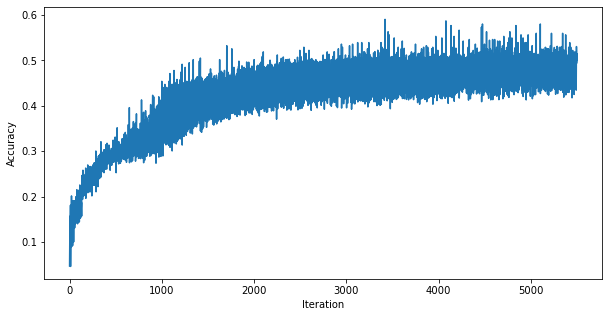

In [17]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

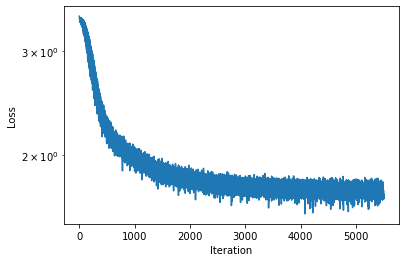

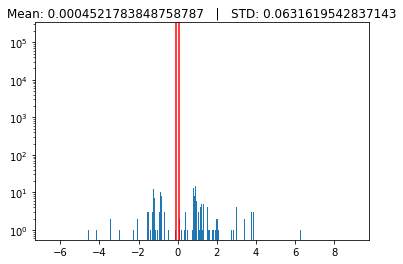

In [18]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

In [30]:
import sys
sys.executable

'/home/eitan.k/miniconda3/envs/rambo/bin/python'

# Tree Visualization

Average height: 8.492753623188406


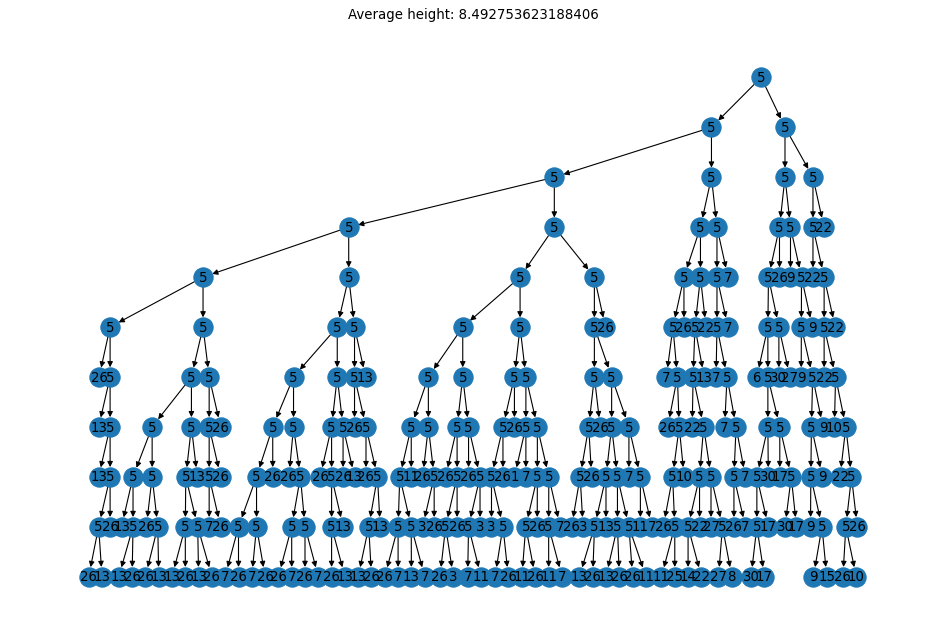

In [31]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [32]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 138


In [33]:
method = 'MLE'

In [34]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [35]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()